In [1]:
# Import files
import os
import numpy as np 
import pandas as pd 
import itertools
from scipy.stats import norm, skew, mode
import re
import gc
import string
import warnings 
import operator

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping
from keras.metrics import Precision, Recall

2024-05-21 22:44:49.185154: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 22:44:49.185255: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 22:44:49.325180: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# read dataframe
df = pd.read_csv('../input/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv')

#Find out number of rows & columns in data
print ('Number of (rows,columns): ' + str(df.shape) )

# take a look
df.head()

Number of (rows,columns): (23486, 11)


Unnamed: 0  Clothing ID  Age                    Title  \
0           0          767   33                      NaN   
1           1         1080   34                      NaN   
2           2         1077   60  Some major design flaws   
3           3         1049   50         My favorite buy!   
4           4          847   47         Flattering shirt   

                                         Review Text  Rating  Recommended IND  \
0  Absolutely wonderful - silky and sexy and comf...       4                1   
1  Love this dress!  it's sooo pretty.  i happene...       5                1   
2  I had such high hopes for this dress and reall...       3                0   
3  I love, love, love this jumpsuit. it's fun, fl...       5                1   
4  This shirt is very flattering to all due to th...       5                1   

   Positive Feedback Count   Division Name Department Name Class Name  
0                        0       Initmates        Intimate  Intimates  
1                        4         General         Dresses    Dresses  
2                        0         General         Dresses    Dresses  
3                        0  General Petite         Bottoms      Pants  
4                        6         General            Tops    Blouses

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [4]:
df.describe(include='all')

Unnamed: 0   Clothing ID           Age     Title  \
count   23486.000000  23486.000000  23486.000000     19676   
unique           NaN           NaN           NaN     13993   
top              NaN           NaN           NaN  Love it!   
freq             NaN           NaN           NaN       136   
mean    11742.500000    918.118709     43.198544       NaN   
std      6779.968547    203.298980     12.279544       NaN   
min         0.000000      0.000000     18.000000       NaN   
25%      5871.250000    861.000000     34.000000       NaN   
50%     11742.500000    936.000000     41.000000       NaN   
75%     17613.750000   1078.000000     52.000000       NaN   
max     23485.000000   1205.000000     99.000000       NaN   

                                              Review Text        Rating  \
count                                               22641  23486.000000   
unique                                              22634           NaN   
top     Perfect fit and i've gotten so many compliment...           NaN   
freq                                                    3           NaN   
mean                                                  NaN      4.196032   
std                                                   NaN      1.110031   
min                                                   NaN      1.000000   
25%                                                   NaN      4.000000   
50%                                                   NaN      5.000000   
75%                                                   NaN      5.000000   
max                                                   NaN      5.000000   

        Recommended IND  Positive Feedback Count Division Name  \
count      23486.000000             23486.000000         23472   
unique              NaN                      NaN             3   
top                 NaN                      NaN       General   
freq                NaN                      NaN         13850   
mean           0.822362                 2.535936           NaN   
std            0.382216                 5.702202           NaN   
min            0.000000                 0.000000           NaN   
25%            1.000000                 0.000000           NaN   
50%            1.000000                 1.000000           NaN   
75%            1.000000                 3.000000           NaN   
max            1.000000               122.000000           NaN   

       Department Name Class Name  
count            23472      23472  
unique               6         20  
top               Tops    Dresses  
freq             10468       6319  
mean               NaN        NaN  
std                NaN        NaN  
min                NaN        NaN  
25%                NaN        NaN  
50%                NaN        NaN  
75%                NaN        NaN  
max                NaN        NaN

In [5]:
#checking for duplicated entries
duplicates = df.duplicated().sum() 
if  duplicates == 0:
    print("There are no duplicted rows in this data")
else:
    print('There are: ', str(duplicates), " duplicates")

There are no duplicted rows in this data


In [6]:
# missing value % and counts
col_with_missing = [c for c in df.columns if df[c].isnull().sum() >= 1]
missing_counts = df[col_with_missing].isnull().sum().sort_values(ascending=False)
total_rows = len(df)
missing_percentages = (missing_counts / total_rows) * 100

#plot
plt.figure(figsize=(15, 2))
ax = missing_percentages.plot.bar(color='#c4bcb3')

for i, (col, count) in enumerate(zip(missing_counts.index, missing_counts)):
    ax.text(i, missing_percentages[i] + 1, f"{count} ({missing_percentages[i]:.1f}%)", ha='center')

plt.ylabel("Missing value %")
plt.title("Missing value % of columns with missing values")
plt.show()

/tmp/ipykernel_26/339275575.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(i, missing_percentages[i] + 1, f"{count} ({missing_percentages[i]:.1f}%)", ha='center')


In [7]:
# Delete rows with missing values in "Review Text"
print("Rows before deleting missing values in review text: ", df.shape[0])
df.dropna(subset=['Review Text'], inplace=True)
print("Rows after deleting missing values in review text: ", df.shape[0])

Rows before deleting missing values in review text:  23486
Rows after deleting missing values in review text:  22641


In [8]:
# Fill in missing values with blank for other object type columns
col_with_missing.remove('Review Text')
for c in col_with_missing:
    if c=='Title':
           df[c] =df[c].fillna(' ')
    else:
           df[c]=df[c].fillna('Blank')
                    
df.isna().sum().sum()

0

In [9]:
# Drop "Unamed: 0" column
df.drop("Unnamed: 0", axis=1, inplace=True)

In [10]:
# check duplicates
print(f"Rows with duplicates: {df.duplicated().sum()}")

Rows with duplicates: 1


There is only 1 duplicates, we can just drop it.

In [11]:
# Drop duplicates
df.drop_duplicates(inplace=True)
print(f"Rows in df after dropping duplicates: {df.shape[0]}")

Rows in df after dropping duplicates: 22640


In [12]:
# Plot dependent variable distribution
# parameters for plot
sizes = df['Recommended IND'].value_counts()
labels = ["1", "0"]
explode = (0, 0.1)  #pull out second slice by 10%
colors = ['#c4bcb3', '#bb9383']  

# Pie chart 
plt.pie(x=sizes, labels=labels, explode=explode, shadow=True, autopct=lambda p: '{:.0f} ({:.0f}%)'.format(p * sum(sizes) / 100, p), colors=colors)
plt.title('Portion of Postive and Negative reviews')
plt.legend(title="Recommended IND", loc="upper right", labels=[f"Recommended ({sizes[0]})", f"Not Recommended ({sizes[1]})"])
plt.show()


In [13]:
# Check total Cloth items in dataset
print("Clothing Item Counts in dataset: ", len(df["Clothing ID"].unique()))

Clothing Item Counts in dataset:  1179


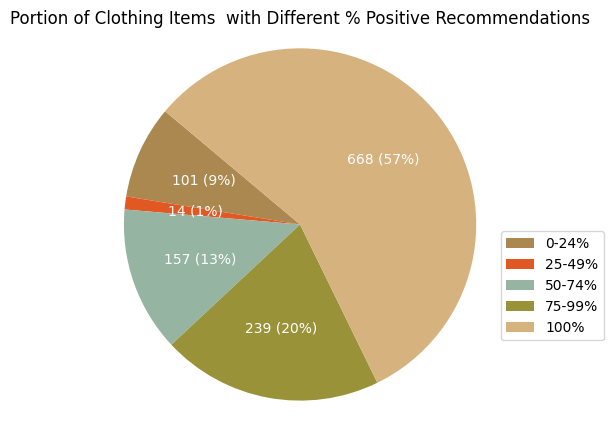

In [14]:
# Pie chart for % of positive recommendation for each of clothing item

# Calculate the percentage of positive feedback for each clothing item & Bin the data into specified ranges
positive_percentage = (df.groupby('Clothing ID')['Recommended IND'].mean() * 100)
bins = [0, 25, 50, 75, 99, 101]
labels = ['0-24%', '25-49%', '50-74%', '75-99%', '100%']
binned_percentage = pd.cut(positive_percentage, bins=bins, labels=labels, right=False)
colors=['#aa884f', '#e25822',  '#96b4a2', '#9a9238','#d6b27f']

# Proportion of items falling into each bin
percentage_counts = binned_percentage.value_counts(normalize=True) * 100
counts = binned_percentage.value_counts()
data = pd.DataFrame({'Percentage': percentage_counts, 'Count': counts})
data = data.reindex(labels)

# Pie Chart 
plt.figure(figsize=(5, 5))
plt.pie(data['Percentage'], labels=data.index, autopct=lambda p: '{:.0f} ({:.0f}%)'.format(p * sum(data['Count']) / 100, p), colors=colors,textprops={'color': 'white'}, startangle=140)
plt.title('Portion of Clothing Items  with Different % Positive Recommendations')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.show()

In [15]:
#Find continuous, discrete, and text features 
col_cont=[]
col_disc=[]
col_text=[]

for c in df.columns:  
    if (c in ['Review Text','Title']):
        col_text.append(c)
    elif (df[c].dtype=='object') or c=='Rating' or c=="Recommended IND":
        col_disc.append(c)
    else:
        col_cont.append(c)
        
#Take a look at features
print(f"Continuous features:\n {col_cont}")
print(f"Discrete features:\n {col_disc}")
print(f"Text features:\n {col_text}")

Continuous features:
 ['Clothing ID', 'Age', 'Positive Feedback Count']
Discrete features:
 ['Rating', 'Recommended IND', 'Division Name', 'Department Name', 'Class Name']
Text features:
 ['Title', 'Review Text']


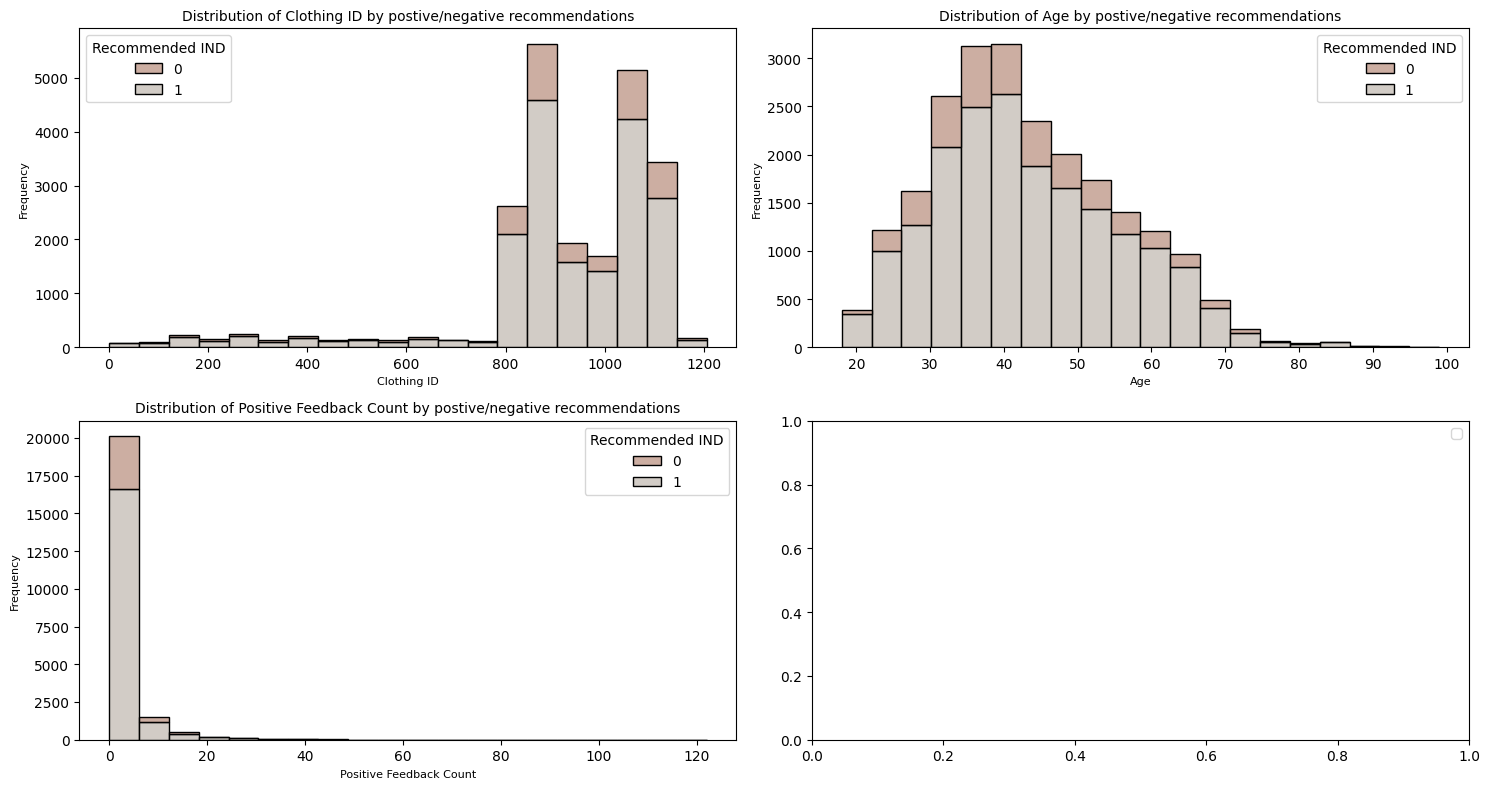

In [16]:
# Continuous Features - histogram by recommend ID
warnings.filterwarnings("ignore", category=FutureWarning)

# plot
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
for idx, feature in enumerate(col_cont):
    row = idx // 2
    col = idx % 2
    
    sns.histplot(data=df, x=feature, hue='Recommended IND', bins=20, ax=ax[row, col], palette=[ '#bb9383', '#c4bcb3'], multiple='stack')
    plt.legend()
    ax[row, col].set_title(f'Distribution of {feature} by postive/negative recommendations',fontsize=10)
    ax[row, col].set_xlabel(feature, fontsize=8)
    ax[row, col].set_ylabel('Frequency', fontsize=8)
 
plt.tight_layout()
plt.show()

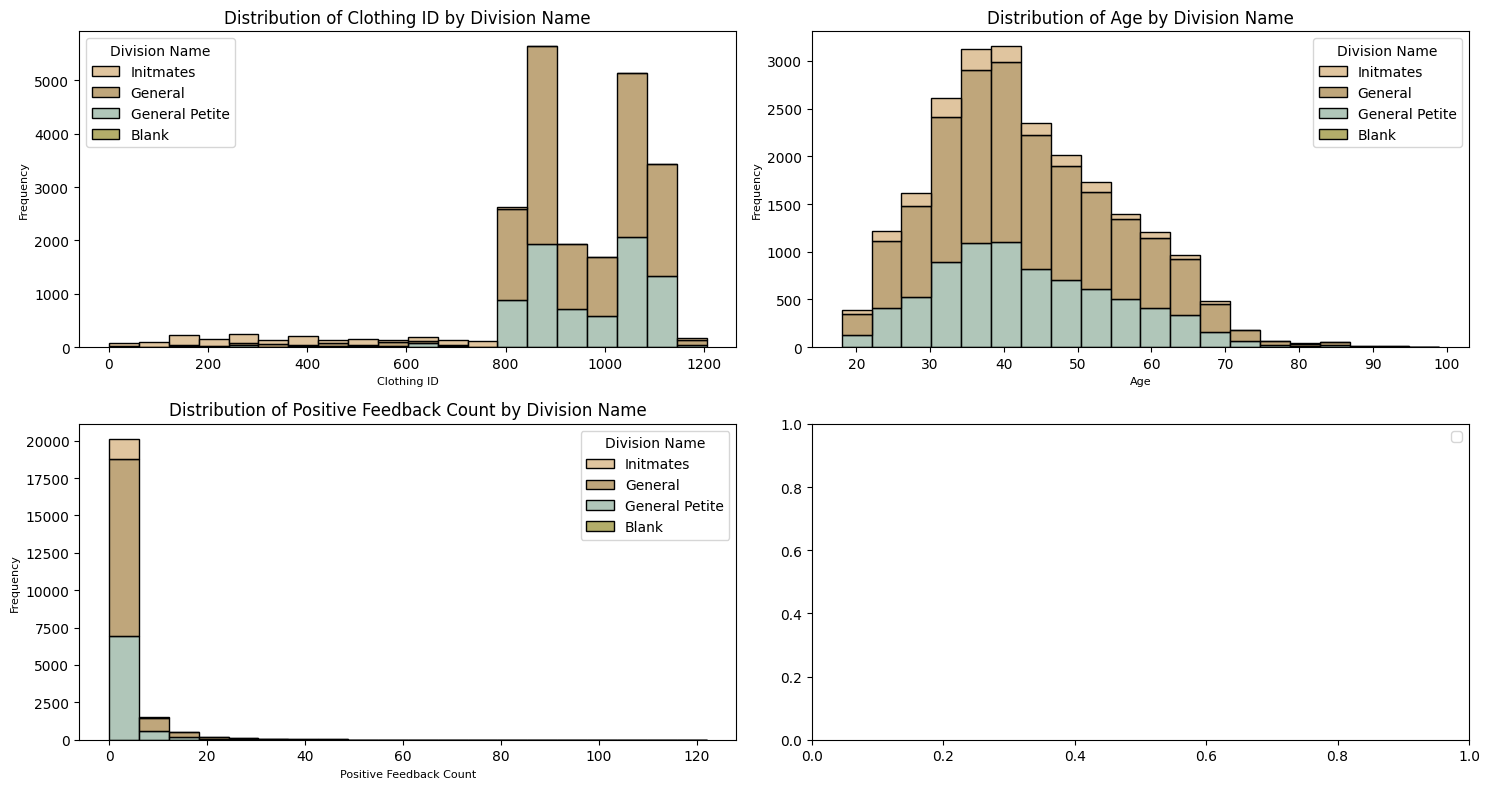

In [17]:
# Continuous Features - histogram by Division Name
warnings.filterwarnings("ignore", category=FutureWarning)

# plot
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
for idx, feature in enumerate(col_cont):
    row = idx // 2
    col = idx % 2
    
    sns.histplot(data=df, x=feature, hue='Division Name', bins=20,ax=ax[row, col],palette= ['#d6b27f', '#aa884f', '#96b4a2', '#9a9238'],multiple='stack')
    plt.legend()
    ax[row, col].set_title(f'Distribution of {feature} by Division Name')
    ax[row, col].set_xlabel(feature, fontsize=8)
    ax[row, col].set_ylabel('Frequency', fontsize=8)
    
plt.legend()
plt.tight_layout()
plt.show()

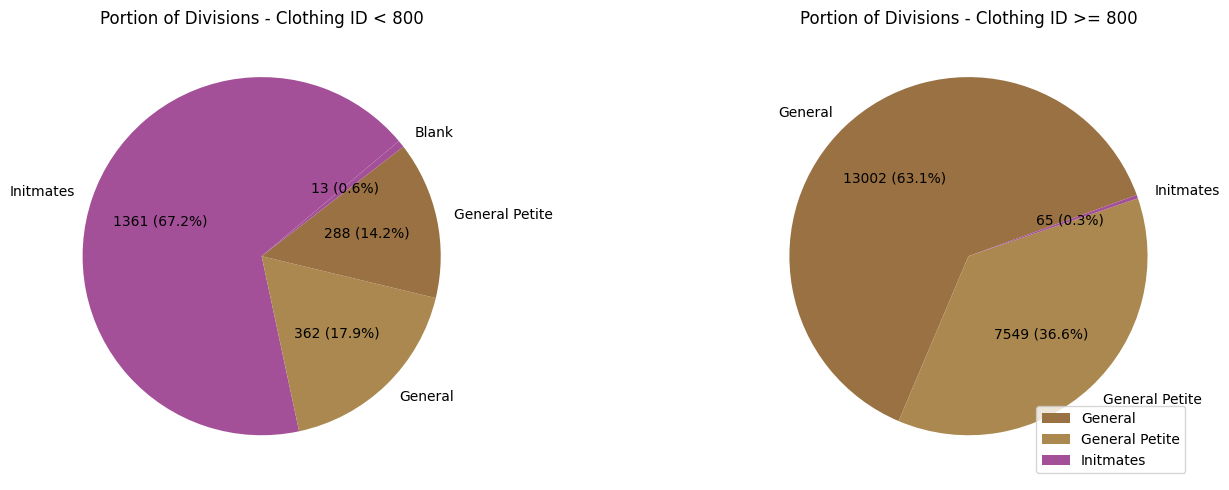

In [18]:
# Pie chart by Clothing ID <800 and >800
df_clothing_0 = df[df['Clothing ID'] < 800]
df_clothing_1 = df[df['Clothing ID'] >= 800]

colors_0=['#a35098', '#aa884f','#9a7142']
colors_1=['#9a7142', '#aa884f', '#a35098']
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Pie chart for clothing ID < 800
clothing_0 = df_clothing_0['Division Name'].value_counts()
ax[0].pie(clothing_0, labels=clothing_0.index, autopct=lambda p: '{:.0f} ({:.1f}%)'.format(p * sum(clothing_0) / 100, p), colors=colors_0, startangle=40)
ax[0].set_title('Portion of Divisions - Clothing ID < 800')
plt.legend()

# Pie chart for clothing ID >= 800
clothing_1 = df_clothing_1['Division Name'].value_counts()
ax[1].pie(clothing_1, labels=clothing_1.index, autopct=lambda p: '{:.0f} ({:.1f}%)'.format(p * sum(clothing_1) / 100, p),colors=colors_1, startangle=20)
ax[1].set_title('Portion of Divisions - Clothing ID >= 800')
plt.legend()

plt.tight_layout()
plt.show()


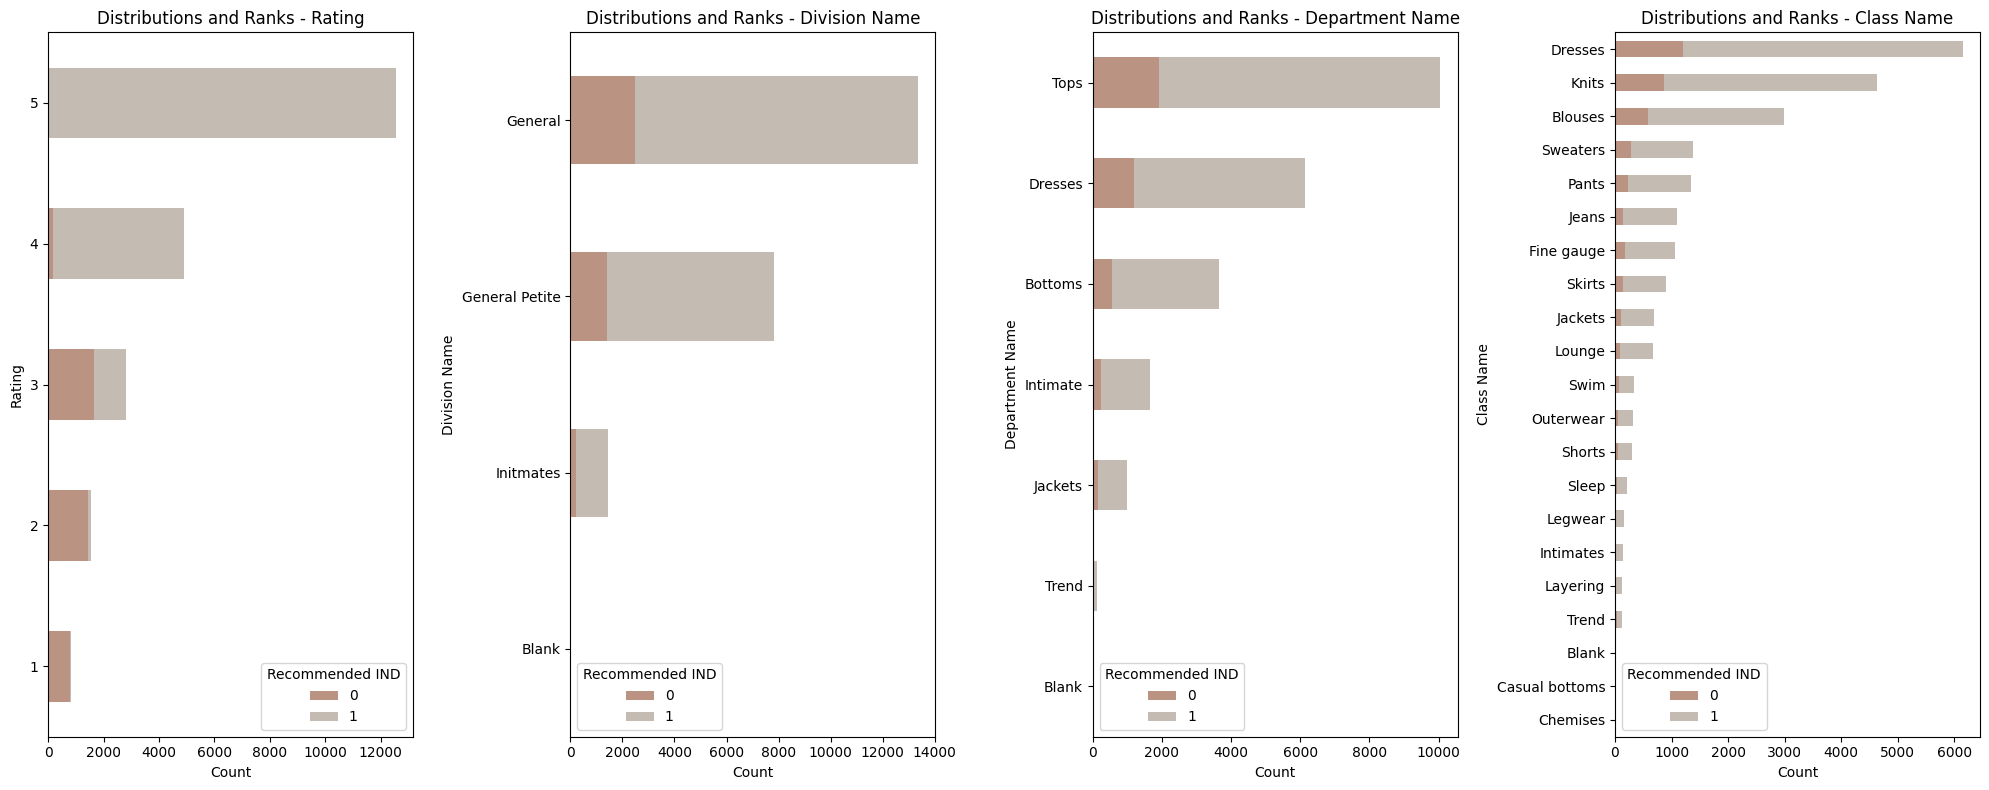

In [19]:
# bar plot for all discrete features - by recommended IND
fig, ax = plt.subplots(1, 4, figsize=(20, 8))  # Adjusted subplot layout to 1 row and 4 columns

cols = [c for c in col_disc if c != 'Recommended IND']

for count, feature in enumerate(cols, 0):
    if feature == 'Recommended IND':
        continue
    
    counts = df.groupby([feature, 'Recommended IND']).size().unstack(fill_value=0)
    counts = counts.loc[counts.sum(axis=1).sort_values(ascending=True).index]

    counts.plot(kind='barh', stacked=True, ax=ax[count], color=['#bb9383', '#c4bcb3'])  # Use barh for horizontal bar chart
    
    ax[count].set_xlabel("Count")  # Set xlabel to Count
    ax[count].set_ylabel(feature, fontsize='medium')  # Set ylabel to feature
    ax[count].set_title(f'Distributions and Ranks - {feature}')
    ax[count].tick_params(axis='y', labelrotation=0)  # Rotate y-axis labels horizontally

plt.tight_layout()
plt.show()


In [20]:
# Pie plot by Ratings
df_recommended_0 = df[df['Recommended IND'] == 0]
df_recommended_1 = df[df['Recommended IND'] == 1]
colors_0=['#9a9238', '#96b4a2', '#e25822', '#aa884f', '#d6b27f']
colors_1=['#d6b27f', '#aa884f', '#9a9238', '#96b4a2', '#e25822'] #order of 54321

# Create two subplots for the pie charts
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Pie chart for Recommended IND = 0
sizes_0 = df_recommended_0['Rating'].value_counts()
ax[0].pie(sizes_0, labels=sizes_0.index, autopct=lambda p: '{:.0f} ({:.1f}%)'.format(p * sum(sizes_0) / 100, p), colors=colors_0,startangle=40)
ax[0].set_title('Portion of Ratings Among Recommended IND = 0')

# Pie chart for Recommended IND = 1
sizes_1 = df_recommended_1['Rating'].value_counts()
ax[1].pie(sizes_1,labels=sizes_1.index, autopct=lambda p: '{:.0f} ({:.1f}%)'.format(p * sum(sizes_1) / 100, p), colors=colors_1,startangle=20,pctdistance=0.9)
ax[1].set_title('Portions of Ratings Among Recommended IND = 1')
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
# Get unique department names
departments = df['Department Name'].unique()
num_rows = 2
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))

for i in range(num_rows):
    for j in range(num_cols):
        if i * num_cols + j < len(departments):
            department = departments[i * num_cols + j]
            department_data = df[df['Department Name'] == department]
            counts = department_data['Class Name'].value_counts().sort_values(ascending=True)
            counts.plot(kind='barh', ax=axes[i, j], color='#c4bcb3')

            axes[i, j].set_title(f'Classes Distributions under Department of {department}', fontsize=12)
            axes[i, j].set_xlabel('Class Name', fontsize=10)
            axes[i, j].set_ylabel('Count', fontsize=10)
            axes[i, j].tick_params(axis='x', rotation=10)
        else:
            # Hide empty subplots
            axes[i, j].axis('off')

plt.tight_layout()
plt.show()


In [22]:
# unique "Title"
len(df.Title.unique())
print(df['Title'].head(10))

0                                        
1                                        
2                 Some major design flaws
3                        My favorite buy!
4                        Flattering shirt
5                 Not for the very petite
6                    Cagrcoal shimmer fun
7    Shimmer, surprisingly goes with lots
8                              Flattering
9                       Such a fun dress!
Name: Title, dtype: object


#### ✍️ "Title" Feature Observations:
A bit more than half of titles are not unique. So, it seems "Title" are arbitary - user can enter freeely. But 'Title' seems to have some dense infomation. So, I think it makes sense to append this to "Review Text".

### Append 'Title' to 'Review Text'

In [23]:
# Append 'Title' to 'Review Text'
df['Review Text'] = df.apply(lambda row: row['Review Text']  + ' ' + row['Title'], axis=1)

# Drop the "Title" column if it's no longer needed
df.drop(columns=['Title'], inplace=True)


In [24]:
# Train/Test Split
train, test = train_test_split(df, test_size=0.2, random_state=42)
print(f"There are {train.shape[0]} rows in training data")
print(f"There are {test.shape[0]} rows in testing data")

There are 18112 rows in training data
There are 4528 rows in testing data


In [25]:
# Look at texts
print('********************************Recommended texts********************************')
print(train[train['Recommended IND']== 1]['Review Text'].iloc[0],'\n')
print(train[train['Recommended IND']== 1]['Review Text'].iloc[100],'\n')
print(train[train['Recommended IND']== 1]['Review Text'].iloc[200],'\n')

print('********************************Not Recommended texts********************************')
print(train[train['Recommended IND']==0]['Review Text'].iloc[0],'\n')
print(train[train['Recommended IND']==0]['Review Text'].iloc[100],'\n')
print(train[train['Recommended IND']== 0]['Review Text'].iloc[200],'\n')

********************************Recommended texts********************************
I love this! the contrast in much prettier in person. Prettier in person 

I just received this in the mail today and haven't taken it off since! i feel like i should be in a romantic movie with a cute black dress under it. can definitely see myself getting a lot of use out of it. can not wait to wear it for the holidays! In love with this sweater coat! 

The pictures online do not do this justice. i did not even recognize it as the same dress at first. i went a size down and that way it flatters my curves beautifully instead of looking like a robe. it can actually be worn 3 ways- i like closing the closest snap(there's two) in the middle with a skinny belt over it, and a slip dress underneath. this way, the dress has a deep v neck and opens out in front when walking. think 1940's glam. it can also be fully closed like in the picture, or left ope Gorgeous in person 

********************************Not Re

Negative "Message Length" skewness: -0.076229 and kurtosis: -1.182614
Positive "Message Length" skewness: -0.017245 and kurtosis: -1.250387


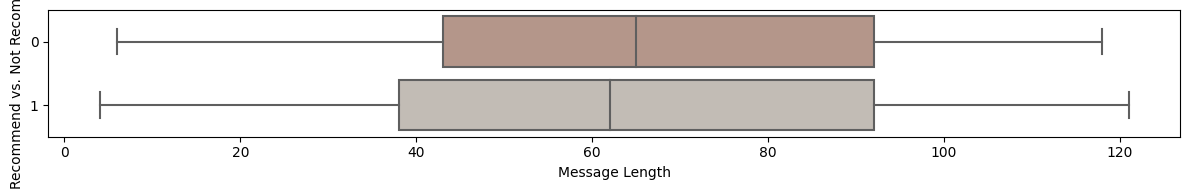

In [26]:
# Create 'message_length' field 
def plot_message_length(df):
        df_copy = df.copy()
        df_copy['message_length'] = df_copy['Review Text'].apply(lambda x: len(x.split(" ")))
        print("Negative \"Message Length\" skewness: %f and kurtosis: %f" % 
              (df_copy[df_copy['Recommended IND'] == 0]['message_length'].skew(), 
               df_copy[df_copy['Recommended IND'] == 0]['message_length'].kurt()))

        print("Positive \"Message Length\" skewness: %f and kurtosis: %f" % 
              (df_copy[df_copy['Recommended IND'] == 1]['message_length'].skew(), 
               df_copy[df_copy['Recommended IND'] == 1]['message_length'].kurt()))

        #Check distribution 
        plt.figure(figsize=(30,3))
        with pd.option_context('mode.use_inf_as_na', True):
            plt.subplot(1, 2, 1)
            sns.histplot(df_copy[df_copy['Recommended IND'] == 0]['message_length'], kde=True, bins=20, color='#bb9383')
            plt.title("Not Recommended Review Text")

            plt.subplot(1, 2, 2)
            sns.histplot(df_copy[df_copy['Recommended IND'] == 1]['message_length'], kde=True, bins=20, color= '#c4bcb3')
            plt.title("Recommended Review Text")
  
        plt.figure(figsize=(12, 2))
        sns.boxplot(data=df_copy, y='Recommended IND', x='message_length', palette={0: '#bb9383', 1: '#c4bcb3'}, orient= 'h')
        plt.xlabel('Message Length')
        plt.ylabel('Recommend vs. Not Recommend')
        
        plt.tight_layout()
        plt.show()
        
plot_message_length(train)

Unique Words in training: 38227
Unique Words in testing: 16811
Unique Words in testing not in training: 4985
Unique Words in both testing and training: 41293


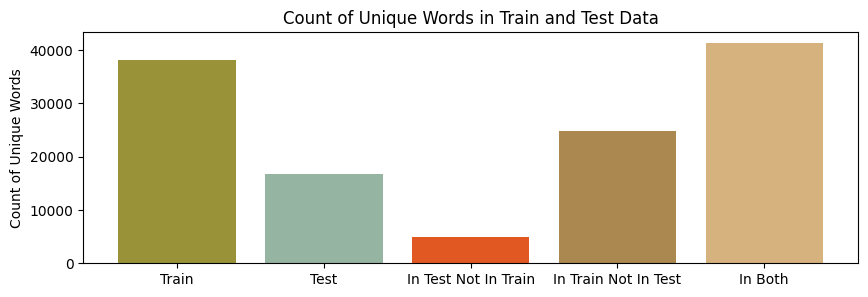

Some sample words in testing not in training:
 ['either--and', 'Pros.', 'material)!', 'bubble-like', 'ones),', 'most-slimming', 'Charcoal,', 'online,,', 'Pays', 'seasonless,', 'hourglass;', 'seeming', 'honolulu', '"in".', 'rules!', 'antebellum', 'actuallly', 'shawl/wrap!', 'hangs).', 'tegan.', '(8p),', 'halterneck', 'lining!', 'sprung', '(32ddd', 'ltitle', 'turtlenceck,', 'restriction,', 'countertops.', 'taste!', 'bronzed', 'sleeves...they', 'souers', 'shoulders,can', 'pilcro)', 'tolerance.', 'reason(you', 'scuba', '(36c),', '10"),', '(width),', 'firmness', 'cloud', 'praise!!', 'super-layered,', 'curvier..', 'Supremely', 'overstretched,', 'teal!', 'directions)', 'materila:', 'mentioend', 'above--', 'port', 'etc!!', 'con?', 'tenty', 'restocks', 'casual),', 'tangl', 'polyester;', 'suede"', 'light-grey', 'pre-fall', 'uncuffed,', '"grooves",', '32d.â', 'narrowis', 'pleat)', 'loveee', 'slouch-y.', '"window"', 'crochet),', "'just'", '(nearly', 'versatile;', 'skills.', 'hips...will', 'nesrly'

38227

In [27]:
# Unqiue words
def unique_words_train_test(col, n=600):
        # First let's check number of unique words in training and testing
        unique_words_train = len(train[col].str.split(" ").explode().unique())
        unique_words_test = len(test[col].str.split(" ").explode().unique())

        # Find words in test not in train
        unique_words_train_list = set(train[col].str.split().explode().unique())
        unique_words_test_list = set(test[col].str.split().explode().unique())
        words_in_test_not_train = list(unique_words_test_list.difference(unique_words_train_list))
        words_in_train_not_test = list(unique_words_train_list.difference(unique_words_test_list))
        words_in_both_train_and_test = list(unique_words_train_list.union(unique_words_test_list))
        
        # Some output
        print("Unique Words in training:", unique_words_train)
        print("Unique Words in testing:", unique_words_test)
        print("Unique Words in testing not in training:", len(words_in_test_not_train))
        print("Unique Words in both testing and training:", len(words_in_both_train_and_test))

        # plot
        plt.figure(figsize=(10,3))
        plt.bar(['Train', 'Test','In Test Not In Train','In Train Not In Test',"In Both"], [unique_words_train, unique_words_test, len(words_in_test_not_train), len(words_in_train_not_test), len(words_in_both_train_and_test)], 
                 color=['#9a9238', '#96b4a2', '#e25822', '#aa884f', '#d6b27f'])
        plt.title('Count of Unique Words in Train and Test Data')
        plt.ylabel('Count of Unique Words')
        plt.show()
        
        print("Some sample words in testing not in training:\n", words_in_test_not_train[:300])
        return unique_words_train
        
unique_words_train_test('Review Text')

<div style="background-color: #f4f4f4; padding: 10px;">
<span style="font-size: larger;">
    
#### Meta Features

In NLP, "Meta-features" are additional features or characteristics derived from the data that are used to augment the original dataset for analytical and modeling purposes. Inspired by this [notebook](https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert). We will create some 'Meta Features" and compare to see their distriubtions in recommended and not recommended review texts. Also,we'll look at their distributions in training vs. tesings set because the distribution discrepancy between training and testing can affect testing predictions:
- **word_count**: number of words in text
- **unique_word_count**: number of unique words in text
- **stop_word_count**: number of stop words in text
- **url_count**: number of urls in text
- **mean_word_length**: average character count in words
- **char_count**:number of characters in text
- **punctuation_count**: number of punctuations in text


In [28]:
#sourcr code from https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert
# word_count
train['word_count'] = train['Review Text'].apply(lambda x: len(str(x).split()))
test['word_count'] = test['Review Text'].apply(lambda x: len(str(x).split()))

# unique_word_count
train['unique_word_count'] = train['Review Text'].apply(lambda x: len(set(str(x).split())))
test['unique_word_count'] = test['Review Text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
stop_words = nltk.corpus.stopwords.words('english')
train['stop_word_count'] = train['Review Text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))
test['stop_word_count'] = test['Review Text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))

# mean_word_length
train['mean_word_length'] = train['Review Text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test['mean_word_length'] = test['Review Text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
train['char_count'] = train['Review Text'].apply(lambda x: len(str(x)))
test['char_count'] = test['Review Text'].apply(lambda x: len(str(x)))

# punctuation_count
train['punctuation_count'] = train['Review Text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test['punctuation_count'] = test['Review Text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))


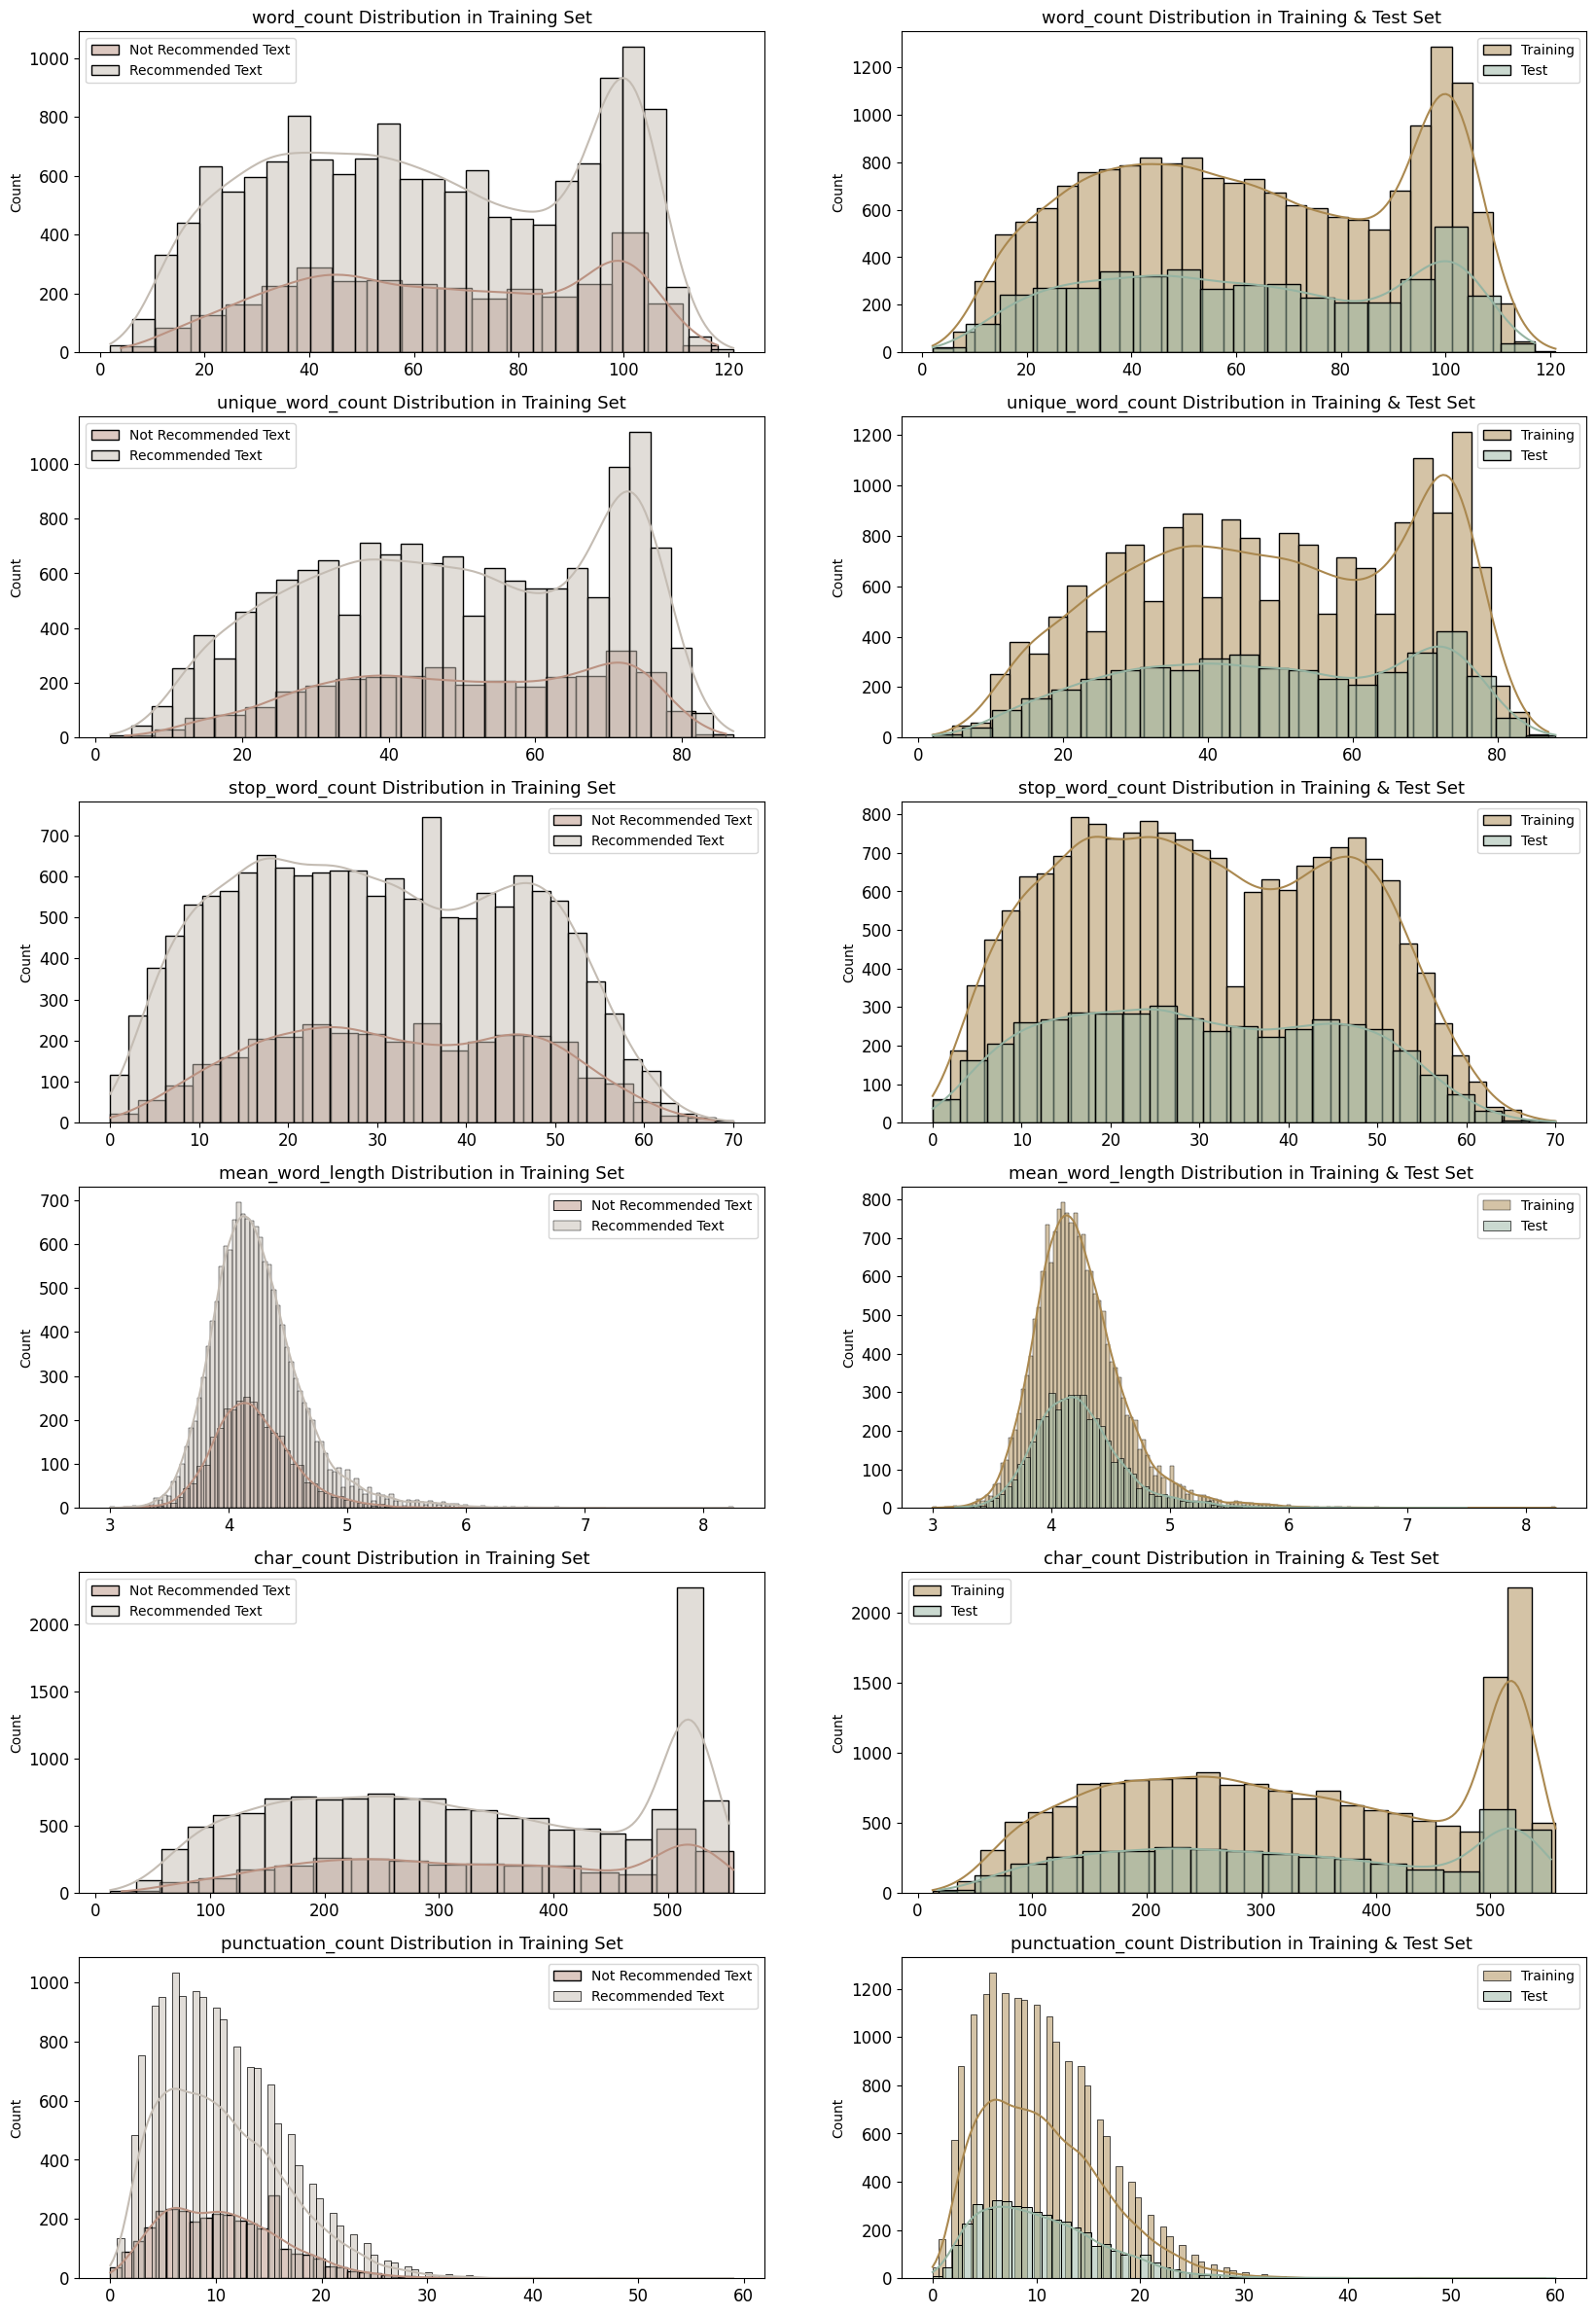

In [29]:
# Source code https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert

# histograms for Meta-Features

warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated", category=FutureWarning) # Suppress FutureWarning


METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count',  'mean_word_length',
                'char_count', 'punctuation_count']
RECOMMENDED = train['Recommended IND'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 30), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.histplot(train.loc[~RECOMMENDED][feature], label='Not Recommended Text', ax=axes[i][0], color='#bb9383', kde=True)
    sns.histplot(train.loc[RECOMMENDED][feature], label='Recommended Text', ax=axes[i][0], color='#c4bcb3', kde=True)
    sns.histplot(train[feature], label='Training', ax=axes[i][1], color='#aa884f', kde=True)
    sns.histplot(test[feature], label='Test', ax=axes[i][1], color='#96b4a2', kde=True)
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Distribution in Training & Test Set ', fontsize=13)

plt.show()

In [30]:
# function for n-grams
def ngram_freqplot(df, color='skyblue', target=" "):
    fig, axs = plt.subplots(1, 4, figsize=(20,10))  
    for i in range(1, 5):
        # Use CountVectorizer to get ngram
        vectorizer = CountVectorizer(ngram_range=(i, i), stop_words='english')
        ngram_train = vectorizer.fit_transform(df['Review Text'])

        # Calculate the frequency of each n-gram and store in dictionary 
        ngram_freq = ngram_train.sum(axis=0)
        feature_names = vectorizer.get_feature_names_out()
        ngram_dict = {feature_names[j]: ngram_freq[0, j] for j in range(len(feature_names))}
        
        # Filter out n-grams containing URLs
        ngram_dict = {ngram: freq for ngram, freq in ngram_dict.items() if not re.match(r'(http|https)', ngram)}
        
        sorted_ngrams = sorted(ngram_dict.items(), key=lambda x: x[1], reverse=True)

        # top n-grams 
        top_n = 30  # Adjust the number of top n-grams you want to plot
        top_ngrams = [item[0] for item in sorted_ngrams[:top_n]]
        top_frequencies = [item[1] for item in sorted_ngrams[:top_n]]

        # bar plot
        axs[i-1].barh(top_ngrams, top_frequencies, color=color)
        axs[i-1].set_title(f'{target} tweet top 30 {i}-gram ')
        axs[i-1].invert_yaxis()  # want highest frequency at the top
        axs[i-1].tick_params(axis='x') 

        # font size for the words 
        for tick in axs[i-1].get_yticklabels():
            tick.set_fontsize(15)
    plt.tight_layout()

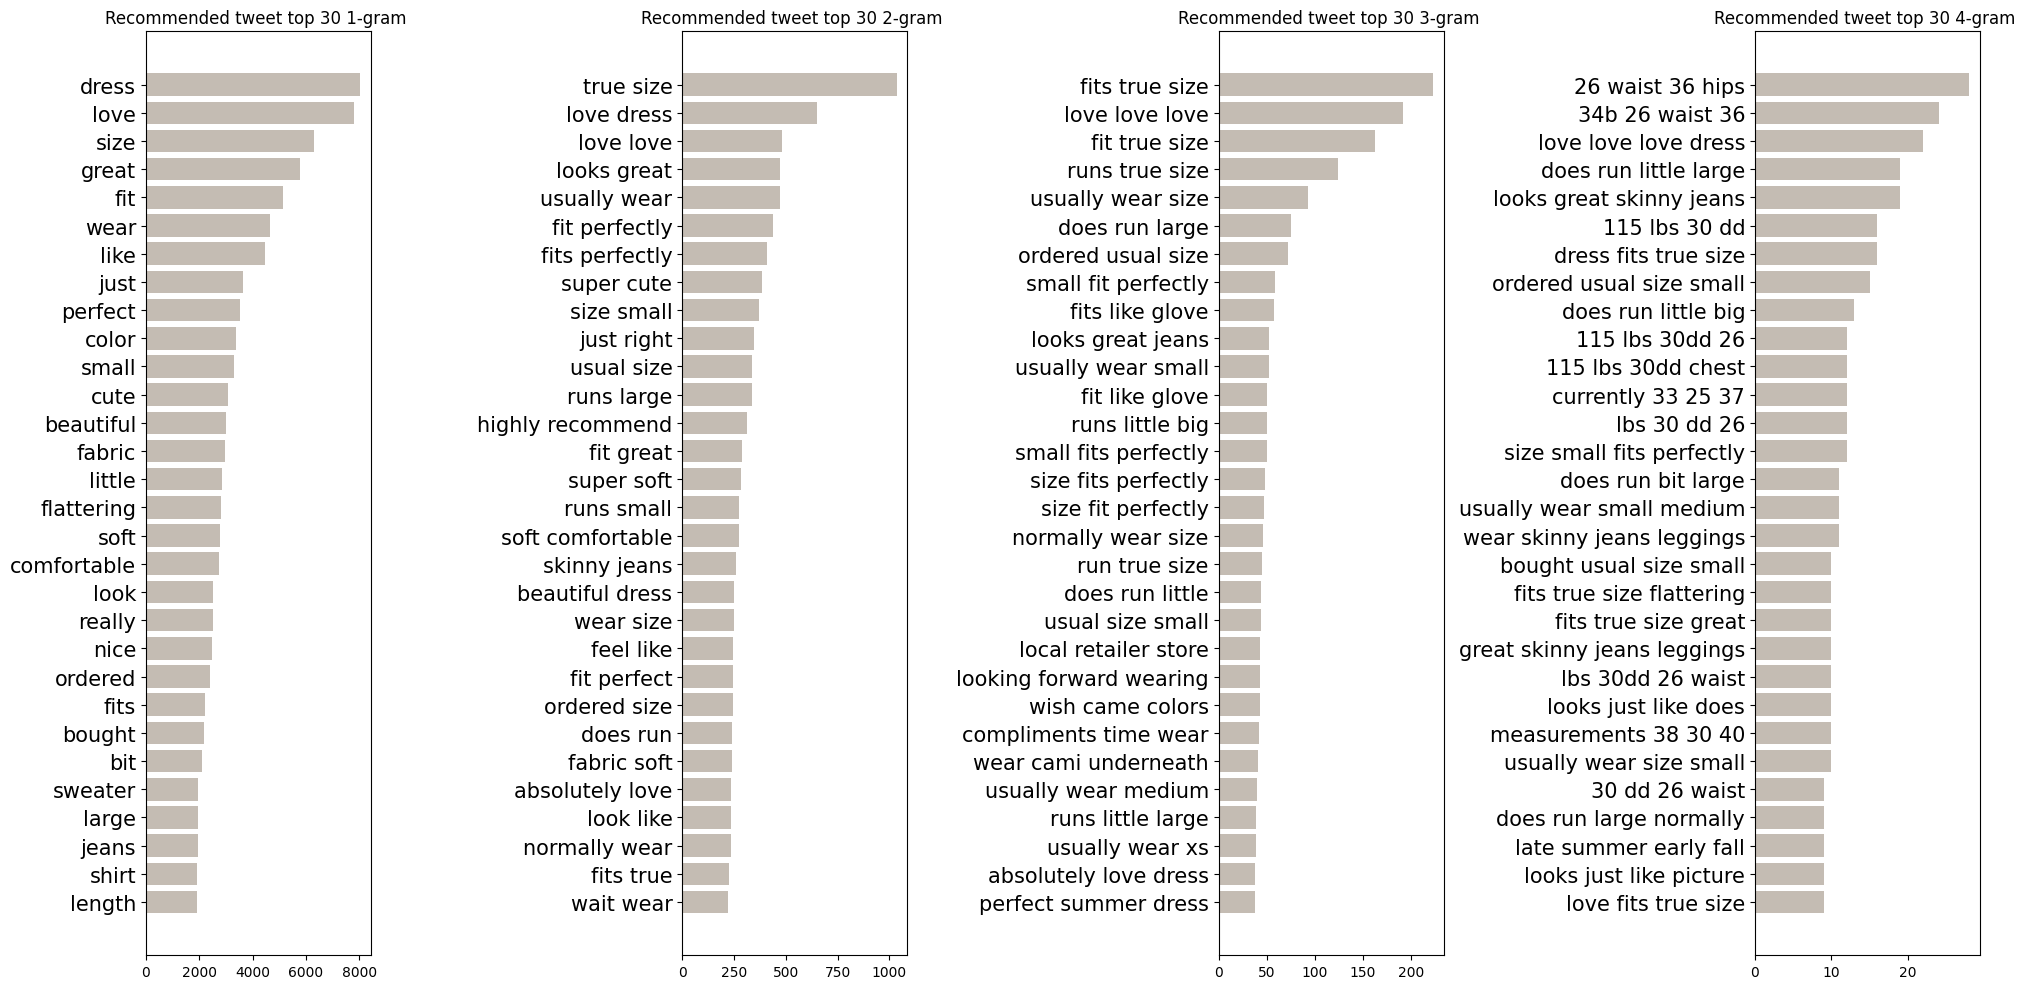

In [31]:
# Recommended Text
ngram_freqplot(train[train['Recommended IND']==1], color='#c4bcb3', target="Recommended")

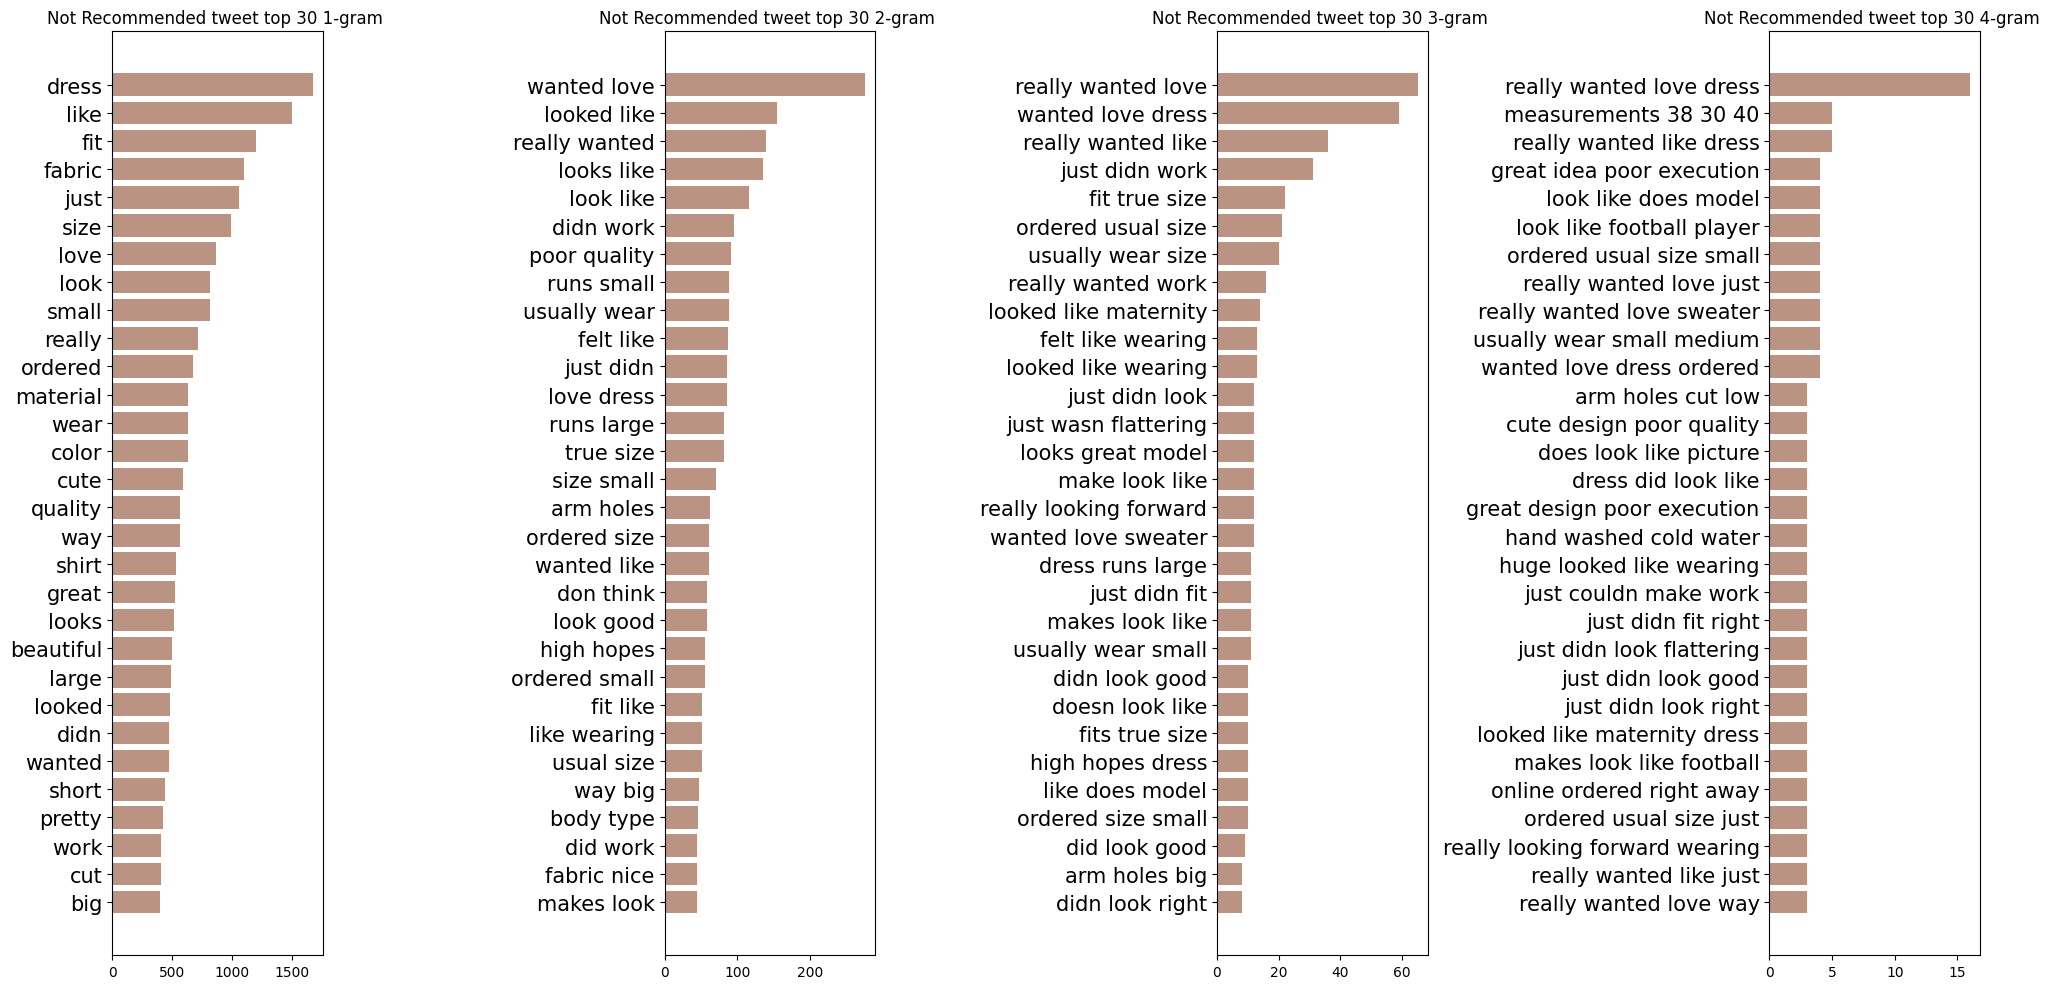

In [32]:
# Not Recommended Text
ngram_freqplot(train[train['Recommended IND']==0], color='#bb9383', target="Not Recommended")

In [33]:
def text_preprocessing(text):
    # convert to lower case
    text = text.str.lower()
    
    # Remove punctuation 
    text = text.apply(lambda doc: re.sub(r'[^\w\s]', '', doc))
    
    # Remove numbers
    text = text.apply(lambda doc: re.sub(r'\d+', '', doc))

    # remove stopwords
    stop_words = nltk.corpus.stopwords.words('english')
    text = text.apply(lambda doc: ' '.join([word for word in doc.split() if word not in stop_words]))

    # stemming
    porter_stemmer = PorterStemmer()
    text = text.apply(lambda doc: ' '.join([porter_stemmer.stem(word) for word in word_tokenize(doc)]))
    
    # Lemmatization - have lookup error,Resource 'corpora/wordnet' not found.
#     lemmatizer = WordNetLemmatizer()
#     text = text.apply(lambda doc: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(doc)]))

    # remove extra spaces
    text = text.apply(lambda doc: re.sub(' +', ' ', doc))

    return text

In [34]:
# Text preprocessing
train['clean_text'] = text_preprocessing(train['Review Text'])
test['clean_text'] = text_preprocessing(test['Review Text'])

In [35]:
# Take a look at before and after text cleaning sample
print(train['Review Text'][1],"\n")
print(train['clean_text'][1],"\n")
print(train['Review Text'][2],"\n")
print(train['clean_text'][2],"\n")

Love this dress!  it's sooo pretty.  i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite.  i bought a petite and am 5'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.   

love dress sooo pretti happen find store im glad bc never would order onlin bc petit bought petit love length hit littl knee would definit true midi someon truli petit 

I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c Some major design fla

In [36]:
# Word Cloud in training

def generate_wordcloud(df, start, end, colormap='viridis',target='', word='Words'):
    frequency = df.str.split().explode().value_counts()
    words = frequency.index[start:end].tolist()
    counts = frequency.values[start:end].tolist()
    wordcloud_dict = {words[i]: counts[i] for i in range(len(words))}
    wordcloud = WordCloud(width=800, height=400, background_color='white',colormap=colormap).generate_from_frequencies(wordcloud_dict)
    
    plt.figure(figsize=(12, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Most Frequent Words of {target} Texts: Top {start+1} to {end}')
    plt.axis('off')
    plt.show()

generate_wordcloud(train[train['Recommended IND']==1]['clean_text'], 0, 500, colormap= 'copper',target='Recommended')

In [37]:
generate_wordcloud(train[train['Recommended IND']==0]['clean_text'], 0, 500, colormap= 'cividis',target='Not recommended')

Unique Words in training: 12835
Unique Words in testing: 6172
Unique Words in testing not in training: 1706
Unique Words in both testing and training: 14541


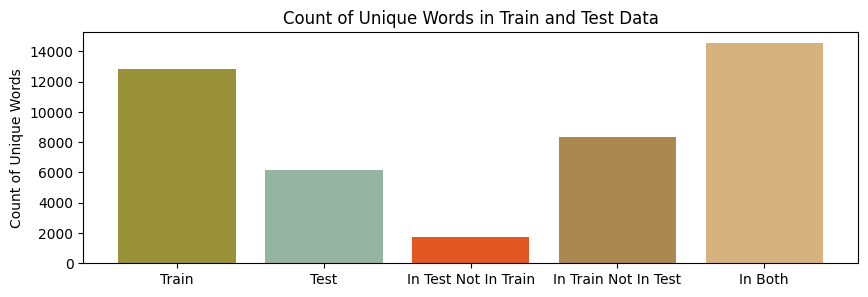

Some sample words in testing not in training:
 ['georgia', 'jeanscord', 'hastl', 'evoc', 'tula', 'veganfriendli', 'lookfit', 'itwhich', 'vibranc', 'pullinggap', 'nantucket', 'groundfin', 'largey', 'purpleblu', 'narrowi', 'skewedim', 'peachthen', 'firstbut', 'antebellum', 'bearabl', 'billowpuffbag', 'modelthin', 'caveatth', 'silhouettebut', 'announc', 'halterneck', 'mouth', 'sprung', 'hosieri', 'unvari', 'reservedli', 'antip', 'coop', 'waistthi', 'molt', 'fronti', 'kimonostyl', 'stretchyi', 'sortof', 'firn', 'blizzard', 'worseit', 'waiver', 'unatur', 'coverin', 'scuba', 'jeanstrous', 'approprialti', 'rufflefabr', 'bottomback', 'washabledry', 'flowyer', 'hopefulluy', 'sec', 'nay', 'cook', 'ast', 'backwardsth', 'heelhoweverm', 'fringelik', 'mentioend', 'port', 'olivedark', 'drumstick', 'foolishli', 'akin', 'comfrotbal', 'overshadow', 'ewww', 'surmount', 'witha', 'contract', 'shouldersbicep', 'poodl', 'straplessand', 'oneit', 'intrepid', 'kneesin', 'yasss', 'materialif', 'peepto', 'wellpro

In [38]:
# Now let's take a look again the unique words in training and testing data
unique_words_train=unique_words_train_test('clean_text',n=100)

In [39]:
# Get X and y df in train and test set
X_train = train.drop(columns=['Recommended IND'])  
y_train =  train['Recommended IND']

X_test = test.drop(columns=['Recommended IND'])  
y_test =  test['Recommended IND']

In [40]:
# Tokenizer using Tensorflow Keras
VOCAB_SIZE = unique_words_train # unique words in training set
OOV_TOKEN ="<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words= VOCAB_SIZE , split=' ', oov_token=OOV_TOKEN)

# Generate the word index dictionary for the training sentences - important to only train on training set.
tokenizer.fit_on_texts(X_train['clean_text']) 
word_index = tokenizer.word_index

# Generate and pad sequences
sequences_train = tokenizer.texts_to_sequences(X_train['clean_text'].values)
padded_train = pad_sequences(sequences_train)
max_length = max(len(seq) for seq in padded_train)# Find maximum sequence length

sequences_test = tokenizer.texts_to_sequences(X_test['clean_text'].values)
padded_test = pad_sequences(sequences_test,maxlen=max_length, truncating='post')

print("Maximum sequence length:", max_length)

Maximum sequence length: 63


In [41]:
# Take a look at tokenization results
print('Cleaned Text: ', X_train['clean_text'][0],'\n')
print('Sequence: ', sequences_train[0],'\n')
print('Padded sequence: ',padded_train[0],'\n')

Cleaned Text:  absolut wonder silki sexi comfort 

Sequence:  [2, 822, 41, 664, 92, 664, 92] 

Padded sequence:  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   2 822  41 664  92 664  92] 



## Model 1 v1. 

In [42]:
# Build the model
NUM_EPOCHS = 15
BATCH_SIZE = 128
EMBEDDED_DIM =100
MAX_LEN = 120
LEARNING_RATE = 0.0001

model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDED_DIM),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
 

# Setup the training parameters
initial_learning_rate = LEARNING_RATE

# Compile the model with binary_crossentropy loss, Adam optimizer, and standard metrics
model1.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=LEARNING_RATE),
              metrics=['accuracy', tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.AUC(name='auc')])
# Train the model
history_model1 = model1.fit(padded_train, y_train, epochs=NUM_EPOCHS, validation_data=(padded_test, y_test), batch_size = BATCH_SIZE)

Epoch 1/15
 62/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6104 - auc: 0.5195 - loss: 0.6885 - precision: 0.8187 - recall: 0.6730

I0000 00:00:1716331593.059227      74 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716331593.076148      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


142/142 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.7000 - auc: 0.5159 - loss: 0.6613 - precision: 0.8170 - recall: 0.8154 - val_accuracy: 0.8174 - val_auc: 0.5178 - val_loss: 0.4921 - val_precision: 0.8174 - val_recall: 1.0000
Epoch 2/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8195 - auc: 0.5195 - loss: 0.4838 - precision: 0.8195 - recall: 1.0000 - val_accuracy: 0.8174 - val_auc: 0.5599 - val_loss: 0.4781 - val_precision: 0.8174 - val_recall: 1.0000
Epoch 3/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8214 - auc: 0.6053 - loss: 0.4630 - precision: 0.8214 - recall: 1.0000 - val_accuracy: 0.8174 - val_auc: 0.8529 - val_loss: 0.4242 - val_precision: 0.8174 - val_recall: 1.0000
Epoch 4/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8272 - auc: 0.8673 - loss: 0.3910 - precision: 0.8271 - recall: 0.9999 - val_accuracy: 0.8664 - val_auc: 0.9253 - val_loss: 0.3339 - val_precision: 0.8658 - val_recall: 0.9900
Epoch 5/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s

In [43]:
# Build the model - less layers, train less
NUM_EPOCHS = 13
BATCH_SIZE = 128
EMBEDDED_DIM =100
MAX_LEN = 120
LEARNING_RATE = 0.0001
DROP_OUT=0.1

model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDED_DIM),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dropout(DROP_OUT),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
 

# Setup the training parameters
initial_learning_rate = LEARNING_RATE

# Compile the model with binary_crossentropy loss, Adam optimizer, and standard metrics
model1.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=LEARNING_RATE),
              metrics=['accuracy', tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.AUC(name='auc')])
# Train the model
history_model1 = model1.fit(padded_train, y_train, epochs=NUM_EPOCHS, validation_data=(padded_test, y_test), batch_size = BATCH_SIZE)

Epoch 1/13
142/142 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.8141 - auc: 0.5256 - loss: 0.5437 - precision: 0.8187 - recall: 0.9926 - val_accuracy: 0.8174 - val_auc: 0.6365 - val_loss: 0.4704 - val_precision: 0.8174 - val_recall: 1.0000
Epoch 2/13
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8143 - auc: 0.6254 - loss: 0.4688 - precision: 0.8143 - recall: 1.0000 - val_accuracy: 0.8174 - val_auc: 0.8741 - val_loss: 0.4297 - val_precision: 0.8174 - val_recall: 1.0000
Epoch 3/13
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8195 - auc: 0.8474 - loss: 0.4084 - precision: 0.8195 - recall: 1.0000 - val_accuracy: 0.8174 - val_auc: 0.9287 - val_loss: 0.3528 - val_precision: 0.8174 - val_recall: 1.0000
Epoch 4/13
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8168 - auc: 0.9296 - loss: 0.3347 - precision: 0.8168 - recall: 1.0000 - val_accuracy: 0.8174 - val_auc: 0.9370 - val_loss: 0.3002 - val_precision: 0.8174 - val_recall: 1.0000
Epoch 5/13
142/142 ━━━━━━━━━━━━

In [44]:
# Plot results function
def plot_results(history, model_name="", early_stopping_callback=None):
    metrics = ['accuracy', 'loss', 'precision', 'recall']
    titles = [f'{model_name} Accuracy', f'{model_name} Loss', f'{model_name} Precision', f'{model_name} Recall', f'{model_name} F1 Score']
        
    # Calculate F1 score for training and validation data
    train_precision = history.history['precision']
    train_recall = history.history['recall']
    train_f1_scores = [2 * (train_precision[i] * train_recall[i]) / (train_precision[i] + train_recall[i] + 1e-8)
                   for i in range(len(train_precision))]  # Avoid division by zero
    
    val_precision = history.history['val_precision']
    val_recall = history.history['val_recall']
    val_f1_scores = [2 * (val_precision[i] * val_recall[i]) / (val_precision[i] + val_recall[i] + 1e-8)
                     for i in range(len(val_precision))]  # Avoid division by zero
    
    fig, axs = plt.subplots(3, 2, figsize=(20, 15))

    for i, metric in enumerate(metrics):
        row = i // 2
        col = i % 2
        axs[row, col].plot(history.history[metric])
        axs[row, col].plot(history.history[f'val_{metric}'])
        axs[row, col].set_title(titles[i], fontsize=20)  
        axs[row, col].tick_params(axis='both', which='major', labelsize=20)  
        axs[row, col].legend(['Train', 'Validate'], loc='upper left', fontsize=20)

    # Plot F1 score 
    axs[-1, 0].plot(train_f1_scores)
    axs[-1, 0].plot(val_f1_scores)
    axs[-1, 0].set_title(titles[-1], fontsize=20)  
    axs[-1, 0].tick_params(axis='both', which='major', labelsize=20)  
    axs[-1, 0].legend(['Train', 'Validate'], loc='upper left', fontsize=20)
 
    if early_stopping_callback is not None:
        # return best accuracy and corresponding metrics if early stopping
        val_accuracy = history.history['val_accuracy']
        best_index = np.argmax(val_accuracy)
        best_accuracy = val_accuracy[best_index]
        best_precision = val_precision[best_index]
        best_recall = val_recall[best_index]
        best_f1_score = val_f1_scores[best_index]
        return best_accuracy, best_precision, best_recall, best_f1_score
    else:
        # no early stopping callback
        return history.history['val_accuracy'][-1],  val_precision[-1],val_recall[-1],  val_f1_scores[-1]

    plt.tight_layout()
    plt.show()


In [45]:
# Plot results
model1_val_accuracy, model1_val_precision, model1_val_recall ,model1_val_f1_scores = plot_results(history_model1,model_name='Model 1' )
print('model 1 accuracy', model1_val_accuracy)
print("model 1 precision", model1_val_precision)
print("model 1 recall",model1_val_recall)
print("model 1 f1 score",model1_val_f1_scores)

model 1 accuracy 0.9074646830558777
model 1 precision 0.9309348464012146
model 1 recall 0.9578492045402527
model 1 f1 score 0.9442002614737641


In [46]:
# Confusion matrix
def plot_cfm(model, X, y_actual, model_name=""):
        # predictions
        pred_prob = model.predict(padded_test)
        pred_prob = np.transpose(pred_prob)[0]
        y_pred = list(map(lambda x: 0 if x < 0.5 else 1, pred_prob))

        #confusion Matrix
        cfm= confusion_matrix(y_actual, y_pred)
        plt.figure(figsize=(1, 1))
        display = ConfusionMatrixDisplay(confusion_matrix=cfm) 
        display.plot(cmap='Greens')
        plt.title(f'{model_name} Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.gcf().set_size_inches(4, 3) 
        plt.show()
        return y_pred

142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


<Figure size 100x100 with 0 Axes>

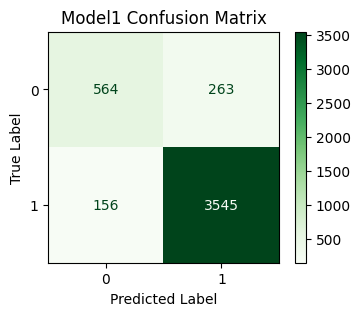

In [47]:
y_pred_model1=plot_cfm(model1,X=padded_test, y_actual= y_test, model_name='Model1')

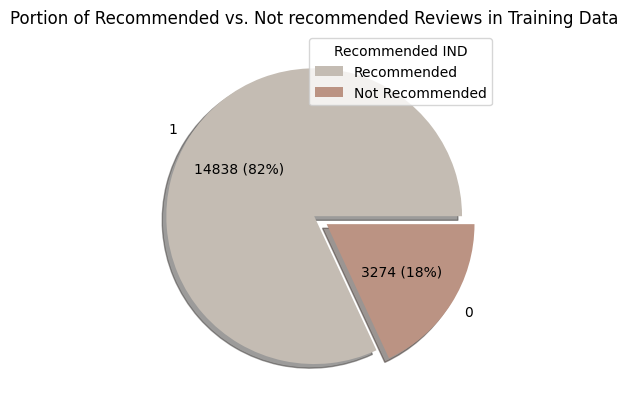

In [48]:
#Plot dependent variable distribution in training set 
#parameters for plot
sizes = train['Recommended IND'].value_counts()
labels = ["1", "0"]
explode = (0, 0.1)  #pull out second slice by 10%
colors = ['#c4bcb3', '#bb9383'] 
# Pie chart 
plt.pie(x=sizes, labels=labels, explode=explode, shadow=True, autopct=lambda p: '{:.0f} ({:.0f}%)'.format(p * sum(sizes) / 100, p), colors=colors)
plt.title('Portion of Recommended vs. Not recommended Reviews in Training Data')
plt.legend(title="Recommended IND", loc="upper right", labels=[f"Recommended", f"Not Recommended"])
plt.show()

In [49]:
# Resampling  in training set - upsampling
#create two different dataframe of majority and minority class 
train_minority = train[(train['Recommended IND']==0)] 
train_majority = train[(train['Recommended IND']==1)] 

# Upsample minority class
train_minority_upsampled = resample(train_minority,
                                    replace=True,  
                                    n_samples=6000,  
                                    random_state=100)

train = pd.concat([train_minority_upsampled, train_majority])
train = train.sample(frac=1, random_state=100)

Positive and Negative Recommended Reviews in training data: 
 Recommended IND
1    14838
0     6000
Name: count, dtype: int64


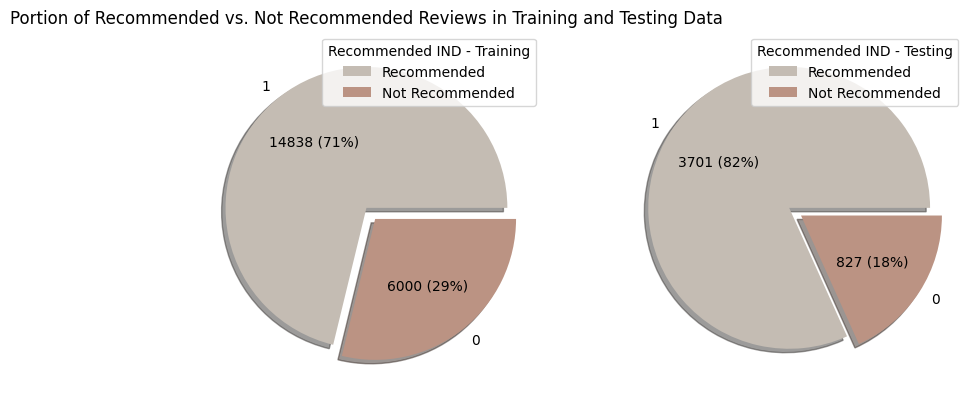

In [50]:
# Plot dependent variable distribution in training and testing set 
# parameters for plot
sizes_train = train['Recommended IND'].value_counts()
sizes_test = test['Recommended IND'].value_counts()
print('Positive and Negative Recommended Reviews in training data: \n',sizes_train)
# Pie chart
plt.figure(figsize=(10, 5))  
plt.subplot(1, 2, 1)
plt.pie(x=sizes_train, labels=labels, explode=explode, shadow=True, autopct=lambda p: '{:.0f} ({:.0f}%)'.format(p * sum(sizes_train) / 100, p), colors=colors)
plt.title('Portion of Recommended vs. Not Recommended Reviews in Training and Testing Data')
plt.legend(title="Recommended IND - Training", loc="upper right", labels=[f"Recommended", f"Not Recommended"])

plt.subplot(1, 2, 2)
plt.pie(x=sizes_test, labels=labels, explode=explode, shadow=True, autopct=lambda p: '{:.0f} ({:.0f}%)'.format(p * sum(sizes_test) / 100, p), colors=colors)
plt.legend(title="Recommended IND - Testing", loc="upper right", labels=[f"Recommended", f"Not Recommended"])
plt.show()

In [51]:
# Get X and y df in train and test set
X_train= train.drop(columns=['Recommended IND'])  
y_train =  train['Recommended IND']

X_test = test.drop(columns=['Recommended IND'])  
y_test =  test['Recommended IND']

In [52]:
# Tokenizer using Tensorflow Keras
VOCAB_SIZE = unique_words_train# unique words in training set
OOV_TOKEN ="<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words= VOCAB_SIZE , split=' ', oov_token=OOV_TOKEN)

# Generate the word index dictionary for the training sentences - important to only train on training set.
tokenizer.fit_on_texts(X_train['clean_text']) 
word_index = tokenizer.word_index

# Generate and pad sequences
sequences_train = tokenizer.texts_to_sequences(X_train['clean_text'].values)
padded_train = pad_sequences(sequences_train)
max_length= max(len(seq) for seq in padded_train)# Find maximum sequence length

sequences_test = tokenizer.texts_to_sequences(X_test['clean_text'].values)
padded_test = pad_sequences(sequences_test,maxlen=max_length, truncating='post')

print("Maximum sequence length:", max_length)

Maximum sequence length: 63


In [53]:
# Build the model
NUM_EPOCHS = 10
BATCH_SIZE = 128
EMBEDDED_DIM =100
LEARNING_RATE = 0.0001
DROP_OUT=0.1

model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE+1, output_dim=EMBEDDED_DIM),
    tf.keras.layers.Flatten(),
#     tf.keras.layers.Dropout(DROP_OUT),
#     tf.keras.layers.Dense(12, activation='relu'),
#     tf.keras.layers.Dropout(DROP_OUT),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dropout(DROP_OUT),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
 

# Compile the model with binary_crossentropy loss, Adam optimizer, and standard metrics
model2.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=LEARNING_RATE),
              metrics=['accuracy', tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.AUC(name='auc')])

In [54]:
# Train the model
history_model2 = model2.fit(padded_train, y_train, epochs=NUM_EPOCHS, validation_data=(padded_test, y_test), batch_size = BATCH_SIZE)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.7040 - auc: 0.5048 - loss: 0.6352 - precision: 0.7152 - recall: 0.9734 - val_accuracy: 0.8174 - val_auc: 0.6029 - val_loss: 0.5156 - val_precision: 0.8174 - val_recall: 1.0000
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7148 - auc: 0.6364 - loss: 0.5828 - precision: 0.7149 - recall: 0.9999 - val_accuracy: 0.8176 - val_auc: 0.8841 - val_loss: 0.4538 - val_precision: 0.8175 - val_recall: 1.0000
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7456 - auc: 0.8772 - loss: 0.4899 - precision: 0.7397 - recall: 0.9943 - val_accuracy: 0.8889 - val_auc: 0.9334 - val_loss: 0.3311 - val_precision: 0.9008 - val_recall: 0.9711
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8679 - auc: 0.9385 - loss: 0.3472 - precision: 0.8689 - recall: 0.9588 - val_accuracy: 0.9026 - val_auc: 0.9407 - val_loss: 0.2629 - val_precision: 0.9287 - val_recall: 0.9541
Epoch 5/10
163/163 ━━━━━━━━━━━━

model 2 accuracy 0.9079063534736633
model 2 precision 0.9411606788635254
model 2 recall 0.9465009570121765
model 2 f2 score 0.9438232589965059


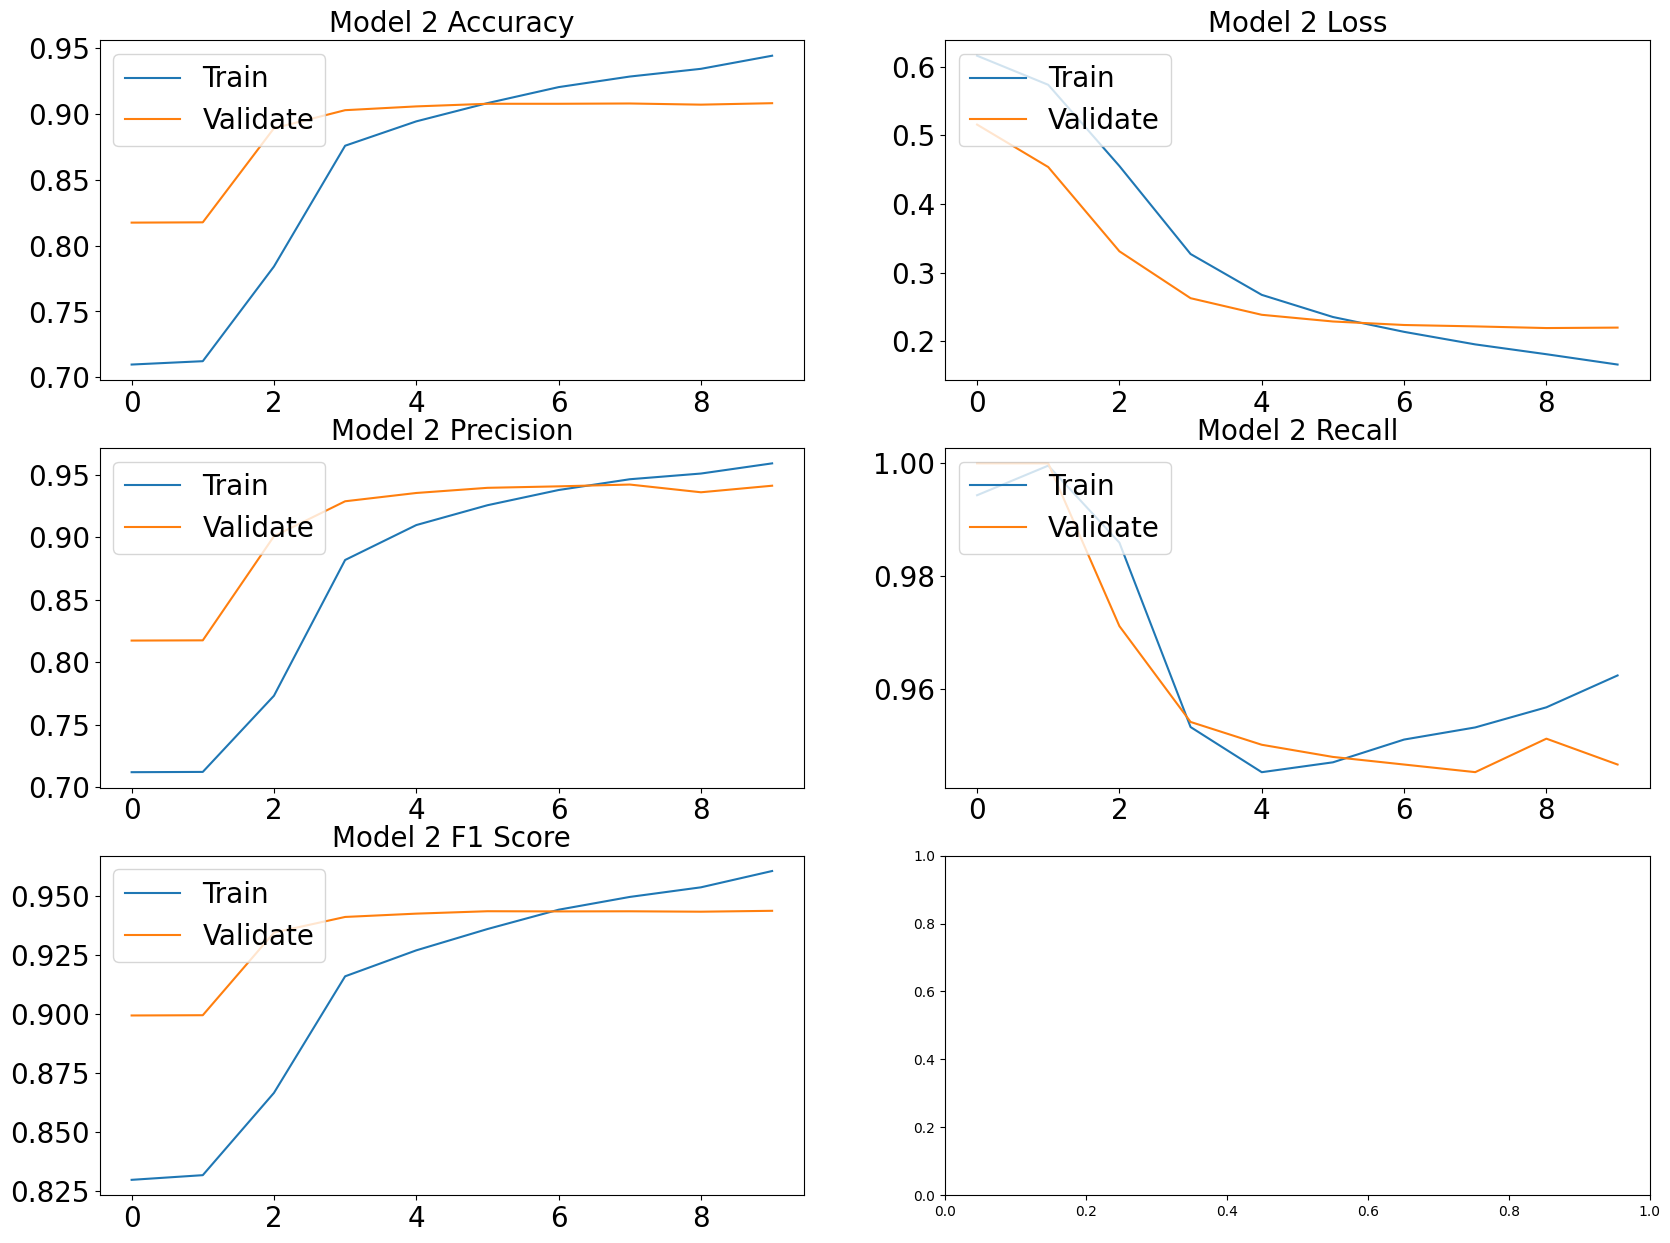

In [55]:
# Plot results
model2_val_accuracy, model2_val_precision, model2_val_recall ,model2_val_f1_scores = plot_results(history_model2,model_name='Model 2' )
print('model 2 accuracy', model2_val_accuracy)
print("model 2 precision", model2_val_precision)
print("model 2 recall",model2_val_recall)
print("model 2 f2 score",model2_val_f1_scores)

In [56]:
y_pred_model2=plot_cfm(model2,X=padded_test, y_actual= y_test, model_name='Model2')

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<Figure size 100x100 with 0 Axes>

In [57]:
# Take a look at false positive, false negative Recommended Text
# function
def fp_fn_look(y_pred_model):
        fp_indices = np.where((np.array(y_pred_model)== 1) & (y_test == 0))[0]
        fn_indices = np.where((np.array(y_pred_model)== 1) & (y_test == 1))[0]

        # False positive
        print('****************************** Not recommended text predicted as recommended (False Positive) ***********************************')
        indices = np.random.choice(fp_indices,2, replace=False)
        for i in indices:
            print(f'text{i}\n', X_test.iloc[i]['clean_text'],'\n' )

        #  False negative
        print('****************************** Recommended Text predicted as not recommended (False Negative) ***********************************')
        indices = np.random.choice(fn_indices,2,replace=False)
        for i in indices:
            print(f'text{i}\n',X_test.iloc[i]['clean_text'] )
            
#model  fp, fn samples
fp_fn_look(y_pred_model2)

****************************** Not recommended text predicted as recommended (False Positive) ***********************************
text1947
 want love kimonoit beauti color would work well mani thing wardrob ala went back due strang feel fabricnot soft touch run small bought ml usual wear couldnt bring kimono togeth front belt option beauti color strang textur 

text2205
 love color design way small wear small mani manufactur certainli one medium like extra small sorri like saw advertis older ladi love well made fresh style need abl trust size true form 

****************************** Recommended Text predicted as not recommended (False Negative) ***********************************
text3287
 like mani issu tri normal size xs couldnt get sale associ look went got sever size small fit differ fit normal other would tri first love fit correctli tri purchas
text4205
 love pant perfect color good weight sometim worri lightcolor pant go see fit wonder true size narrow leg perfect flat boot bo

In [58]:
# Build the model 3
# hyper-papameters
EMBEDDED_DIM = 100
LEARNING_RATE = 0.0002
LEARNING_RATE_MIN=0.0001
DECAY_STEPS = 100 
DECAY_RATE = 0.9
DROP_OUT_REC=0
DROP_OUT_LSTM=0.1
DROP_OUT=0.1
NUM_EPOCHS = 8
BATCH_SIZE = 128

model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE+1, EMBEDDED_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8,  dropout=DROP_OUT_LSTM, recurrent_dropout=DROP_OUT_REC,kernel_regularizer=tf.keras.regularizers.l2(0.001))),
    tf.keras.layers.Dropout(DROP_OUT),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dropout(DROP_OUT),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


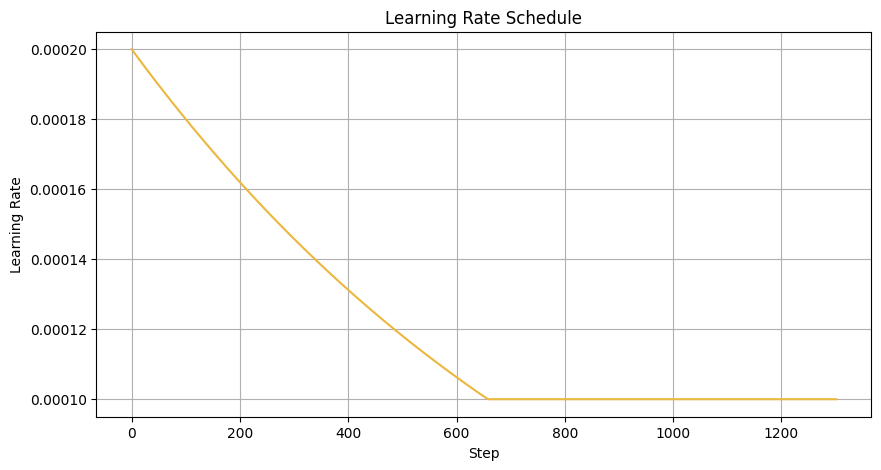

In [59]:
# Define the learning rate scheduler
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, learning_rate_min, decay_steps, decay_rate):
        super(CustomSchedule, self).__init__()
        self.initial_learning_rate = initial_learning_rate 
        self.min_learning_rate = learning_rate_min
        self.decay_steps = decay_steps
        self.decay_rate = decay_rate
        

    def __call__(self, step):
            learning_rate = tf.math.maximum(self.initial_learning_rate * self.decay_rate ** (step  / self.decay_steps), self.min_learning_rate)
            return learning_rate
    
# learning rate scheduler instance
learning_rate_scheduler = CustomSchedule(initial_learning_rate=LEARNING_RATE, learning_rate_min=LEARNING_RATE_MIN ,decay_steps=DECAY_STEPS, decay_rate=DECAY_RATE)

# plot
# Number of steps in training
num_steps = int(X_train.shape[0] /BATCH_SIZE * NUM_EPOCHS )

# Generate learning rates for each step
learning_rates = [learning_rate_scheduler(tf.constant(step, dtype=tf.float32)).numpy() for step in range(num_steps)]

# Plot learning rates
plt.figure(figsize=(10,5))
plt.plot(range(num_steps), learning_rates, color='#ebb73d')
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.grid(True)
plt.show()

#compile model
model3.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_scheduler),
               metrics=['accuracy', tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.AUC(name='auc')])

In [60]:
history_model3 = model3.fit(padded_train, 
                            y_train,
                            epochs=NUM_EPOCHS, 
                            validation_data=(padded_test, y_test), 
                            batch_size=BATCH_SIZE)

Epoch 1/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 29s 133ms/step - accuracy: 0.6841 - auc: 0.5265 - loss: 0.7434 - precision: 0.7133 - recall: 0.9290 - val_accuracy: 0.8174 - val_auc: 0.8979 - val_loss: 0.5892 - val_precision: 0.8174 - val_recall: 1.0000
Epoch 2/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - accuracy: 0.7030 - auc: 0.7738 - loss: 0.6420 - precision: 0.7117 - recall: 0.9776 - val_accuracy: 0.8200 - val_auc: 0.9294 - val_loss: 0.4824 - val_precision: 0.8197 - val_recall: 0.9997
Epoch 3/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 128ms/step - accuracy: 0.7619 - auc: 0.8676 - loss: 0.5243 - precision: 0.7762 - recall: 0.9401 - val_accuracy: 0.8997 - val_auc: 0.9337 - val_loss: 0.4155 - val_precision: 0.9249 - val_recall: 0.9549
Epoch 4/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.8557 - auc: 0.9155 - loss: 0.4457 - precision: 0.8800 - recall: 0.9259 - val_accuracy: 0.9033 - val_auc: 0.9352 - val_loss: 0.3658 - val_precision: 0.9370 - val_recall: 0.9451
Epoch 5/8
163/163 ━━━━━━

model 3 accuracy 0.9023851752281189
model 3 precision 0.9502624869346619
model 3 recall 0.9292083382606506
model 3 f1 score 0.9396174815388725


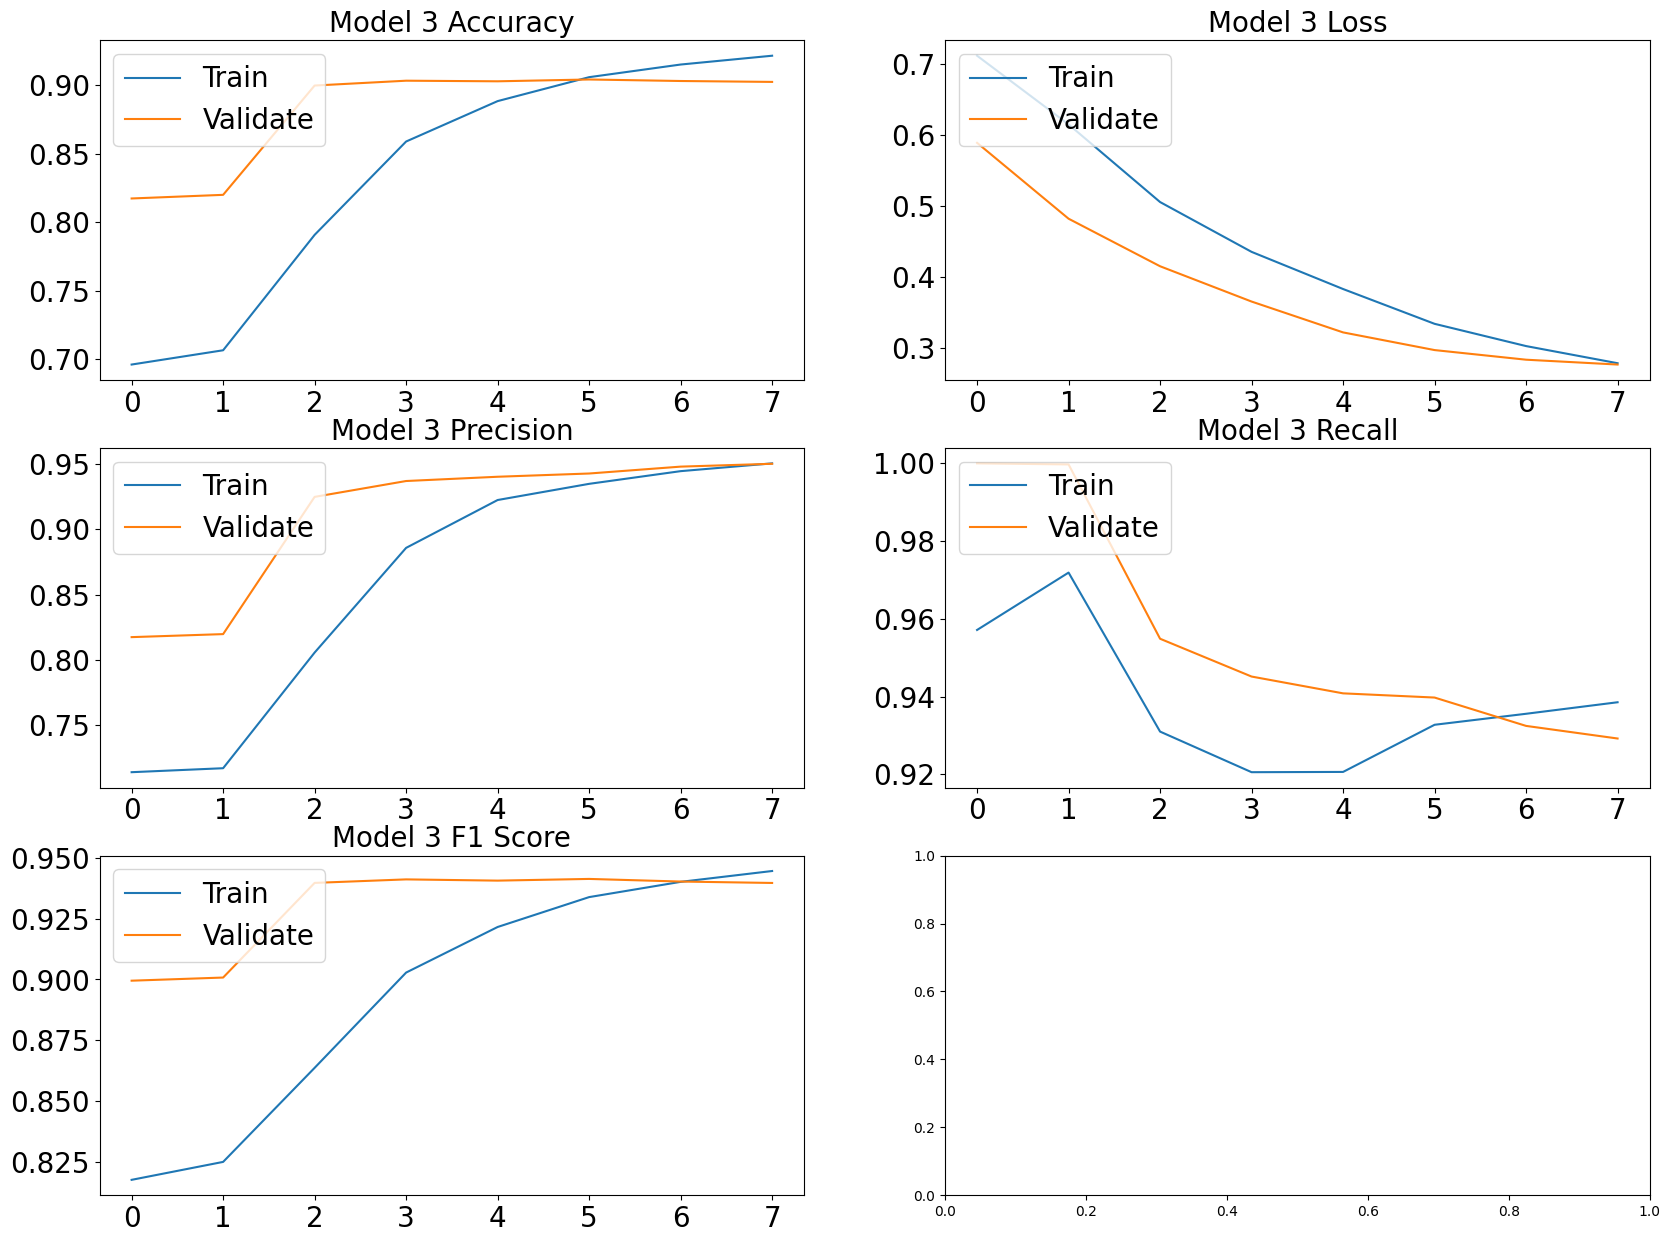

In [61]:
# Plot results
model3_val_accuracy, model3_val_precision, model3_val_recall ,model3_val_f1_scores = plot_results(history_model3,model_name='Model 3' )
print('model 3 accuracy', model3_val_accuracy)
print("model 3 precision", model3_val_precision)
print("model 3 recall",model3_val_recall)
print("model 3 f1 score",model3_val_f1_scores)

In [62]:
y_pred_model3=plot_cfm(model3,X=padded_test, y_actual= y_test, model_name='Model3')

142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step


<Figure size 100x100 with 0 Axes>

In [63]:
#model  fp, fn samples
fp_fn_look(y_pred_model3)

****************************** Not recommended text predicted as recommended (False Positive) ***********************************
text1281
 dont lot pink lavend wardrob time tri shade like alway think compliment skin tone hair color gener wear mauveish copperi eye shadow color shirt look beauti makeup unfortun dont find shape top flatter realli long way model partial tuck look best im realli thin like larger chest doesnt pretti enough price 

text3732
 order dress differ size neither fit tight run small 

****************************** Recommended Text predicted as not recommended (False Negative) ***********************************
text3368
 order larg super cute dress time larg ran super big usual wear sometim medium small im go exchang medium see fit better bead detail beauti much fabric cute littl big
text1360
 dress wait season perfect color materi also firm without heavi thick know mean lay flat smooth bump without overli stiff vneck also deep sleev short overal complet win go ma

In [64]:
GLOVE_FILE = '../input/glove6b100dtxt/glove.6B.100d.txt'
GLOVE_EMBEDDINGS = {}

with open(GLOVE_FILE) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        GLOVE_EMBEDDINGS[word] = coefs

I've tried and pre-processed text doesn't work well for Glove embedding for this data. Let's just use the less or even raw texts.

In [65]:
def text_preprocessing_glove(text):
    
    # Lemmatization - have lookup error,Resource 'corpora/wordnet' not found.
#     lemmatizer = WordNetLemmatizer()
#     text = text.apply(lambda doc: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(doc)]))

    # remove extra spaces
    text = text.apply(lambda doc: re.sub(' +', ' ', doc))

    return text

In [66]:
# Go back and use un-preprocessed text for Glove embedding
train['clean_text'] =text_preprocessing_glove(train['Review Text'])
test['clean_text'] = text_preprocessing_glove(test['Review Text'])

# Tokenizer using Tensorflow Keras
VOCAB_SIZE = unique_words_train # unique words in training set
OOV_TOKEN ="<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words= VOCAB_SIZE , split=' ', oov_token=OOV_TOKEN)

# Generate the word index dictionary for the training sentences - important to only train on training set.
tokenizer.fit_on_texts(X_train['clean_text']) 
word_index = tokenizer.word_index

# Generate and pad sequences
sequences_train = tokenizer.texts_to_sequences(X_train['clean_text'].values)
padded_train = pad_sequences(sequences_train)
max_length = max(len(seq) for seq in padded_train)# Find maximum sequence length

sequences_test = tokenizer.texts_to_sequences(X_test['clean_text'].values)
padded_test = pad_sequences(sequences_test,maxlen=max_length, truncating='post')

print("Maximum sequence length:", max_length)


Maximum sequence length: 63


In [67]:
EMBEDDINGS_MATRIX = np.zeros((VOCAB_SIZE+1, 100))

num = 0
missed_list = []

for word, i in word_index.items():
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX[i] = embedding_vector
    else:
        num += 1
        missed_list.append(word)

print('How many missed words? ',num)
print('As example: ',missed_list[:100])

How many missed words?  7123
As example:  ['<OOV>', 'beauti', 'realli', 'littl', 'larg', 'pretti', 'qualiti', 'sleev', 'pictur', 'onlin', 'howev', 'gorgeou', 'definit', 'piec', 'perfectli', 'comfi', 'blous', 'receiv', 'boxi', 'uniqu', 'unfortun', 'anoth', 'easi', 'versatil', 'slightli', 'probabl', 'someth', 'flowi', 'figur', 'mayb', 'decid', 'everi', 'amaz', 'issu', 'everyth', 'typic', 'skinni', 'heavi', 'excit', 'necklin', 'especi', 'easili', 'extrem', 'arriv', 'unflatt', 'someon', 'surpris', 'curvi', 'embroideri', 'anyth', 'alreadi', 'highli', 'exactli', 'stretchi', 'itchi', 'tshirt', 'wardrob', 'simpl', 'pilcro', 'stapl', 'notic', 'baggi', 'theyr', 'ankl', 'wrinkl', 'textur', 'eleg', 'exchang', 'consid', 'otherwis', 'immedi', 'worri', 'bulki', 'curv', 'addit', 'previou', 'incred', 'awesom', 'elast', 'roomi', 'booti', 'sometim', 'ruffl', 'armhol', 'peopl', 'structur', 'insid', 'scratchi', 'perhap', 'ivori', 'athlet', 'dressi', 'terribl', 'classi', 'coupl', 'fabul', 'substanti', 'maev

In [68]:
# Build the model 
# hyper-papameters
EMBEDDED_DIM =EMBEDDINGS_MATRIX.shape[1]
LEARNING_RATE = 0.0002
LEARNING_RATE_MIN=0.0001
DECAY_STEPS = 100 
DECAY_RATE = 0.9
DROP_OUT_REC=0
DROP_OUT_LSTM=0.1
DROP_OUT=0.1
NUM_EPOCHS =20
BATCH_SIZE = 128

model4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE+1, EMBEDDED_DIM,embeddings_initializer=Constant(EMBEDDINGS_MATRIX ),trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8,  dropout=DROP_OUT_LSTM, recurrent_dropout=DROP_OUT_REC,kernel_regularizer=tf.keras.regularizers.l2(0.001))),
    tf.keras.layers.Dropout(DROP_OUT),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dropout(DROP_OUT),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [69]:
# learning rate scheduler instance
learning_rate_scheduler = CustomSchedule(initial_learning_rate=LEARNING_RATE, learning_rate_min=LEARNING_RATE_MIN ,decay_steps=DECAY_STEPS, decay_rate=DECAY_RATE)

#compile model
model4.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_scheduler),
               metrics=['accuracy', tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.AUC(name='auc')])

In [70]:
history_model4 = model4.fit(padded_train, 
                            y_train,
                            epochs=NUM_EPOCHS, 
                            validation_data=(padded_test, y_test), 
                            batch_size=BATCH_SIZE)

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 131ms/step - accuracy: 0.6210 - auc: 0.5149 - loss: 0.7500 - precision: 0.7141 - recall: 0.7885 - val_accuracy: 0.8174 - val_auc: 0.6548 - val_loss: 0.6065 - val_precision: 0.8174 - val_recall: 1.0000
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.6836 - auc: 0.6230 - loss: 0.6701 - precision: 0.7119 - recall: 0.9297 - val_accuracy: 0.8191 - val_auc: 0.7707 - val_loss: 0.5463 - val_precision: 0.8197 - val_recall: 0.9984
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.7004 - auc: 0.7223 - loss: 0.6181 - precision: 0.7284 - recall: 0.9218 - val_accuracy: 0.8498 - val_auc: 0.8417 - val_loss: 0.4866 - val_precision: 0.8678 - val_recall: 0.9630
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 128ms/step - accuracy: 0.7555 - auc: 0.7907 - loss: 0.5549 - precision: 0.7906 - recall: 0.8942 - val_accuracy: 0.8648 - val_auc: 0.8714 - val_loss: 0.4365 - val_precision: 0.9057 - val_recall: 0.9316
Epoch 5/20
163/163 ━

In [71]:
# Plot results
model4_val_accuracy, model4_val_precision, model4_val_recall ,model4_val_f1_scores = plot_results(history_model4,model_name='Model 4' )
print('model 4 accuracy', model4_val_accuracy)
print("model 4 precision", model4_val_precision)
print("model 4 recall",model4_val_recall)
print("model 4 f1 score",model4_val_f1_scores)

model 4 accuracy 0.900397539138794
model 4 precision 0.9516397714614868
model 4 recall 0.9251553416252136
model 4 f1 score 0.9382106837773581


142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step


<Figure size 100x100 with 0 Axes>

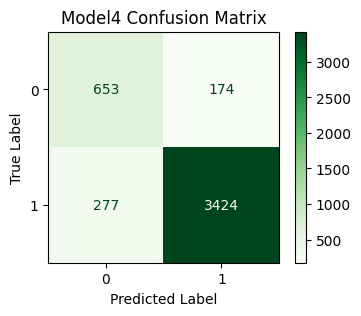

In [72]:
y_pred_model4=plot_cfm(model4,X=padded_test, y_actual= y_test, model_name='Model4')

In [73]:
#model  fp, fn samples
fp_fn_look(y_pred_model4)

****************************** Not recommended text predicted as recommended (False Positive) ***********************************
text1095
 order jean twice love first pair mismark size reorder second pair still didnt fit run realli small would probabl need one mayb two size larger normal achiev fit feel skinni jean closet run small 

text4518
 horribl fit understand alin dress skin non alin camisol dress 

****************************** Recommended Text predicted as not recommended (False Negative) ***********************************
text2265
 cute top agre poster neck front feel littl restrict
text4019
 top super versatilei wear jean weekend also work appropri light perfect warm weather perfect versatil top


In [74]:
# Models' summary
metrics_data = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Model 1": [model1_val_accuracy, model1_val_precision, model1_val_recall, model1_val_f1_scores],
    "Model 2": [model2_val_accuracy, model2_val_precision, model2_val_recall, model2_val_f1_scores],
    "Model 3": [model3_val_accuracy, model3_val_precision, model3_val_recall, model3_val_f1_scores],
    "Model 4": [model4_val_accuracy, model4_val_precision, model4_val_recall, model4_val_f1_scores]
 
}

# Create a DataFrame
metrics_df = pd.DataFrame(metrics_data)
metrics_df.set_index("Metric", inplace=True)
print(metrics_df)


# Plot the data
colors = ['#a35098', '#aa884f','#9a7142','#c4bcb3']
plt.figure(figsize=(10, 5))
metrics_df.T.plot(kind='bar', figsize=(10,5), color=colors)

plt.title('Model Performance Metrics')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

            Model 1   Model 2   Model 3   Model 4
Metric                                           
Accuracy   0.907465  0.907906  0.902385  0.900398
Precision  0.930935  0.941161  0.950262  0.951640
Recall     0.957849  0.946501  0.929208  0.925155
F1 Score   0.944200  0.943823  0.939617  0.938211


<Figure size 1000x500 with 0 Axes>